# **Trabajo Final de NLP**

Actividad realizada por el estudiante: Gabriel Emilio García Mazón

El desafío a realizarse consiste en realizar un estudios exploratorio de 3 modelos en la tarea de clasificación de emociones (https://github.com/fmplaza/EmoEvent/tree/master/splits). Este dataset contiene 8409 tweets anotados con una de las siguientes categorías: anger, sadness, joy, disgust, fear, surprise, offensive, other. Además, los tweets están relacionados a eventos particulares encontrados en Twitter.

Los requerimientos son los siguientes:

* Deben explorar 3 modelos, pueden entrenar los propios (por ejemplo, una Red Neuronal Recurrente o una Sequence-to-Sequence), hacer fine-tuning (por ejemplo de Bert o T5) o usar un modelo ya listo (por ejemplo, GPT-4o). (9 puntos)

* Deben reportar los resultados por cada emoción (categoría) y también realizar un análisis por evento, matriz de confusión entre otras cosas que consideren pertinente. (5 puntos)

* Debe publicar lo desarrollado en un notebook disponible en GitHub. La entrega debe incluir solo el link al repositorio. (3 puntos)

* El notebook debe estar detallado en cada paso. (3 puntos)

Estudio exploratorio de 3 modelos para clasificación de emociones en tweets.
Dataset: 8409 tweets anotados con 8 categorías emocionales.
Modelos implementados:
1. XLM-RoBERTa-base (fine-tuning)
2. DistilBERT multilingüe (fine-tuning)
3. FLAN-T5-base (few-shot prompting)

# 1. CONFIGURACIÓN INICIAL Y INSTALACIÓN DE DEPENDENCIAS

**Objetivo.** Preparar el entorno de trabajo para ejecutar modelos de NLP con PyTorch y Transformers, asegurando **reproducibilidad** y compatibilidad con GPU (si está disponible).

**Qué hacemos aquí**
- Instalamos librerías clave: `transformers`, `torch`, `datasets`, `evaluate`, `scikit-learn`, `pandas`, `numpy`, `matplotlib`, `seaborn`, utilidades para limpieza (`emoji`, `unidecode`).
- Fijamos la **semilla** (`SEED`) en Python/NumPy/PyTorch para obtener resultados consistentes.
- Mostramos el **dispositivo** activo (CPU/GPU) y configuramos opciones de impresión de `pandas` y estilos de gráficos.

> Resultado: el cuaderno queda listo para entrenamiento/inferencia y evaluación.

In [1]:
# ================================================================================================
# 1. CONFIGURACIÓN INICIAL Y INSTALACIÓN DE DEPENDENCIAS
# ================================================================================================

# Instalación de librerías necesarias
!pip install -q transformers torch torchvision datasets accelerate evaluate
!pip install -q scikit-learn pandas numpy matplotlib seaborn
!pip install -q emoji unidecode plotly

# Imports principales
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML y transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, pipeline,
    T5ForConditionalGeneration, T5Tokenizer
)
from datasets import Dataset as HFDataset
import evaluate

# Sklearn
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_recall_fscore_support
)
from sklearn.model_selection import cross_val_score

# Configuración de semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configuraciones generales
warnings.filterwarnings('ignore')
plt.style.use('default')
pd.set_option('display.max_columns', None)

print("Configuración inicial completada")
print(f"Dispositivo disponible: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"Semilla fija: {SEED}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 16.3 MB/s eta 0:00:00
Configuración inicial completada
Dispositivo disponible: CUDA
Semilla fija: 42


# 2. CARGA DE DATOS

**Dataset.** Usamos **EmoEvent** (split en español), con **8 emociones**:
`anger, disgust, fear, joy, offensive, other, sadness, surprise`.

**Qué hace esta sección**
- Descarga los splits `train/dev/test` en formato TSV directo desde GitHub.
- Muestra conteos por split y columnas disponibles.
- Imprime un **ejemplo** de filas para verificar que la lectura sea correcta.

**Por qué es importante**
- Conocer tamaños y campos del dataset permite planificar el modelado (clases desbalanceadas, longitud de textos, etc.).

In [2]:
# ================================================================================================
# 2. CARGA DE DATOS DESDE GITHUB
# ================================================================================================

def download_emoevent_data():
    """
    Descarga los datos del dataset EmoEvent (split español) directamente desde GitHub.
    Retorna los DataFrames de train, dev y test.
    """
    base_url = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/es/"

    # URLs de los archivos
    urls = {
        'train': base_url + 'train.tsv',
        'dev': base_url + 'dev.tsv',
        'test': base_url + 'test.tsv'
    }

    # Descargar cada split
    dataframes = {}
    for split_name, url in urls.items():
        print(f"Descargando {split_name}.tsv...")
        df = pd.read_csv(url, sep='\t', encoding='utf-8')
        dataframes[split_name] = df
        print(f"  - {split_name}: {len(df)} ejemplos")
        print(f"  - Columnas: {list(df.columns)}")

    return dataframes['train'], dataframes['dev'], dataframes['test']

# Cargar datos
df_train, df_dev, df_test = download_emoevent_data()

print("\n" + "="*50)
print("RESUMEN DEL DATASET EMOEVENT")
print("="*50)

# Análisis básico del dataset
total_samples = len(df_train) + len(df_dev) + len(df_test)
print(f"Total de muestras: {total_samples:,}")
print(f"  - Entrenamiento: {len(df_train):,} ({len(df_train)/total_samples*100:.1f}%)")
print(f"  - Desarrollo: {len(df_dev):,} ({len(df_dev)/total_samples*100:.1f}%)")
print(f"  - Prueba: {len(df_test):,} ({len(df_test)/total_samples*100:.1f}%)")

# Mostrar ejemplo de datos
print(f"\nEjemplo de datos (primeras 2 filas de train):")
print(df_train.head(2).to_string())

Descargando train.tsv...
  - train: 5723 ejemplos
  - Columnas: ['id', 'event', 'tweet', 'offensive', 'emotion']
Descargando dev.tsv...
  - dev: 844 ejemplos
  - Columnas: ['id', 'event', 'tweet', 'offensive', 'emotion']
Descargando test.tsv...
  - test: 1656 ejemplos
  - Columnas: ['id', 'event', 'tweet', 'offensive', 'emotion']

RESUMEN DEL DATASET EMOEVENT
Total de muestras: 8,223
  - Entrenamiento: 5,723 (69.6%)
  - Desarrollo: 844 (10.3%)
  - Prueba: 1,656 (20.1%)

Ejemplo de datos (primeras 2 filas de train):
                                     id          event                                                                                                                                                 tweet offensive emotion
0  a0c1a858-a9b8-4cb1-8a81-1602736ff5b8  GameOfThrones  La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas https://t.co/UE7lCgLSez https://t.co/OO3tjUR34c        NO  others
1  9b272817-a231-4f68-bdf4-3350d4

# 3. ANÁLISIS EXPLORATORIO DE DATOS

**Objetivo.** Entender la distribución de emociones y eventos antes de entrenar.

**Panel compacto (figura única)**
- **(a) Distribución por emoción (Total):** permite ver **desbalance** entre clases.
- **(b) Composición por split (100% apiladas):** compara proporciones de cada emoción en Train/Dev/Test.
- **(c) Longitud de tweets por split:** densidades/histogramas y **medianas** de longitud.
- **(d) Longitud por emoción (Train):** violinplot para ver dispersión por clase.
- **(e) Señales sociales por split:** % de tweets con **URLs**, **hashtags** y **emojis**.
- **(f) Top eventos (Train):** eventos más frecuentes.
- **(g) Heatmap evento–emoción (Top-10):** proporciones por fila (cómo se distribuyen las emociones en cada evento).

**Archivos generados**
- `results/eda/EDA_panel.(png|svg)` + CSVs con resúmenes (distribución por emoción, señales sociales, heatmap por evento).


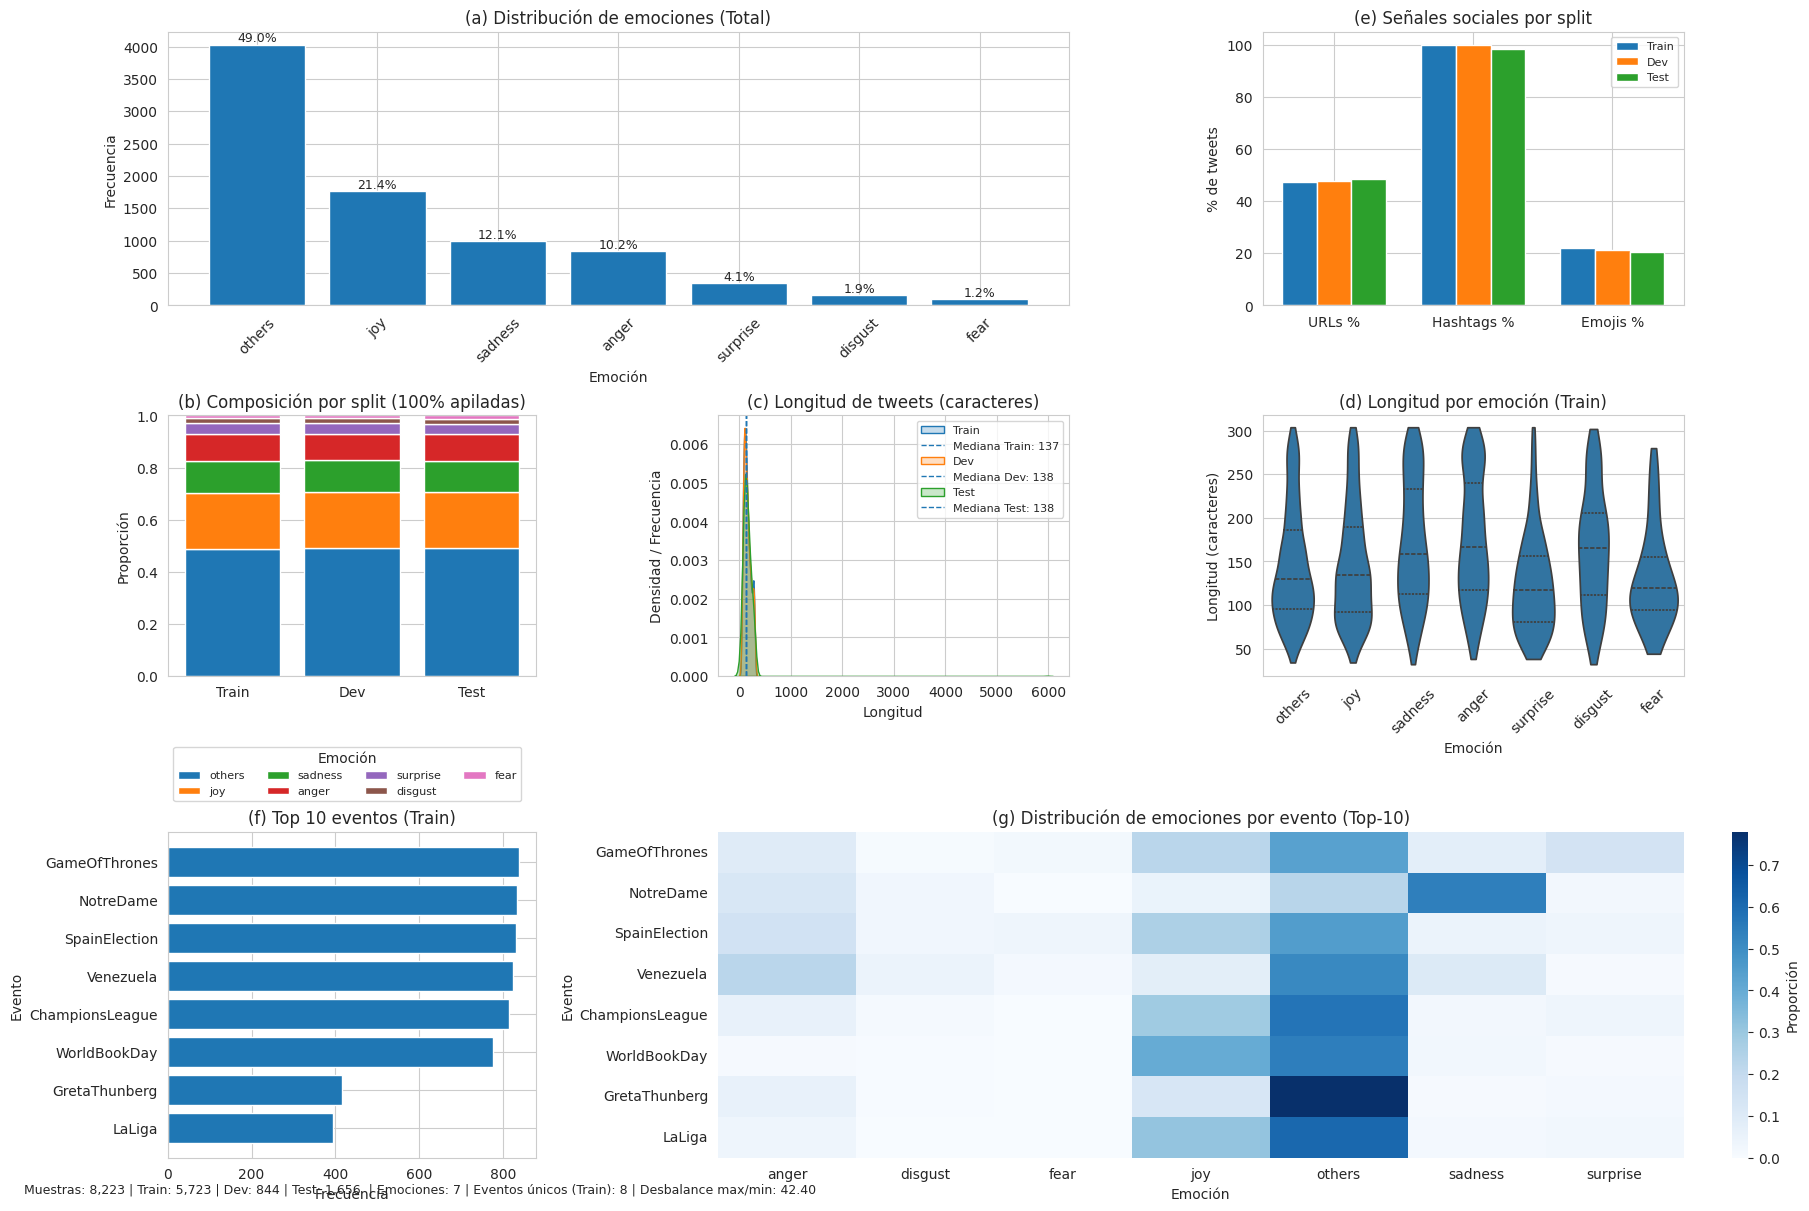


ANÁLISIS EXPLORATORIO DEL DATASET (panel compacto)
          Train  Dev  Test  Total     %
emotion                                
others     2800  414   814   4028  49.0
joy        1227  181   354   1762  21.4
sadness     693  104   199    996  12.1
anger       589   85   168    842  10.2
surprise    238   35    67    340   4.1
disgust     111   16    33    160   1.9
fear         65    9    21     95   1.2

Índice de desbalance (max/min): 42.40

📁 Panel guardado en:
   - results/eda/EDA_panel.png
   - results/eda/EDA_panel.svg


In [3]:
# ================================================================================================
# 3. ANÁLISIS EXPLORATORIO DE DATOS (panel compacto en una sola figura)
# ================================================================================================
def analyze_dataset(df_train, df_dev, df_test, save_dir="results/eda", top_n_events=10):
    """
    EDA compacto en una sola figura (panel único) organizado con GridSpec.
    Devuelve emotion_summary y guarda el panel en results/eda/EDA_panel.png
    """
    import os, re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    try:
        import emoji
    except:
        emoji = None

    os.makedirs(save_dir, exist_ok=True)

    # ---------------------------
    # 1) Tabla de distribución por emoción
    # ---------------------------
    emotions = sorted(pd.Index(
        df_train["emotion"].tolist() + df_dev["emotion"].tolist() + df_test["emotion"].tolist()
    ).unique())

    emotion_counts_train = df_train["emotion"].value_counts().reindex(emotions).fillna(0).astype(int)
    emotion_counts_dev   = df_dev["emotion"].value_counts().reindex(emotions).fillna(0).astype(int)
    emotion_counts_test  = df_test["emotion"].value_counts().reindex(emotions).fillna(0).astype(int)

    emotion_summary = pd.DataFrame({
        "Train": emotion_counts_train,
        "Dev":   emotion_counts_dev,
        "Test":  emotion_counts_test
    })
    emotion_summary["Total"] = emotion_summary.sum(axis=1)
    emotion_summary["%"] = emotion_summary["Total"] / emotion_summary["Total"].sum() * 100
    emotion_summary_sorted = emotion_summary.sort_values("Total", ascending=False)

    # Métricas rápidas
    max_c = emotion_summary_sorted["Total"].max()
    min_c = emotion_summary_sorted["Total"].replace(0, np.nan).min()
    imb_ratio = np.nan if pd.isna(min_c) else (max_c / min_c)
    split_counts = emotion_summary.loc[emotions, ["Train", "Dev", "Test"]]
    prop_by_split = (split_counts / split_counts.sum(axis=0).replace(0, np.nan)).T  # 3xK

    # Longitudes
    def _len_chars(s): return s.astype(str).str.len()
    len_train = _len_chars(df_train["tweet"])
    len_dev   = _len_chars(df_dev["tweet"])
    len_test  = _len_chars(df_test["tweet"])
    df_len = df_train.copy()
    df_len["length"] = df_len["tweet"].astype(str).str.len()
    order_emo = emotion_summary_sorted.index.tolist()

    # Señales sociales
    def social_signals(df):
        s = df["tweet"].astype(str)
        has_url  = s.str.contains(r"(http[s]?://|www\.)", regex=True)
        has_at   = s.str.contains(r"@\w+")
        has_hash = s.str.contains(r"#\w+")
        if emoji is not None:
            has_emoji = s.apply(lambda t: any(ch in emoji.EMOJI_DATA for ch in t))
        else:
            has_emoji = s.str.contains(r"[^\w\s.,;:!?@#/$%&()\"'´`-]")
        return pd.Series({
            "URLs %":       has_url.mean()*100,
            "Hashtags %":   has_hash.mean()*100,
            "Emojis %":     has_emoji.mean()*100
        })

    social_df = pd.DataFrame({
        "Train": social_signals(df_train),
        "Dev":   social_signals(df_dev),
        "Test":  social_signals(df_test)
    })

    # Eventos
    top_events = df_train["event"].value_counts().head(top_n_events).index
    top_event_counts = df_train["event"].value_counts().head(top_n_events).sort_values(ascending=True)
    df_ev = df_train[df_train["event"].isin(top_events)].copy()
    ct = pd.crosstab(df_ev["event"], df_ev["emotion"]).reindex(index=top_events)
    ct_prop = ct.div(ct.sum(axis=1), axis=0).fillna(0)  # proporciones por fila

    # ---------------------------
    # FIGURA ÚNICA (panel compacto)
    # ---------------------------
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(18, 12), constrained_layout=True)
    gs = fig.add_gridspec(
        3, 3,
        height_ratios=[1.05, 1.0, 1.25],
        width_ratios=[1.05, 1.0, 1.2]
    )

    # (a) Distribución total por emoción (barras con %)
    axA = fig.add_subplot(gs[0, 0:2])
    bars = axA.bar(emotion_summary_sorted.index, emotion_summary_sorted["Total"])
    axA.set_title("(a) Distribución de emociones (Total)")
    axA.set_xlabel("Emoción"); axA.set_ylabel("Frecuencia")
    axA.tick_params(axis="x", rotation=45)
    for rect, pct in zip(bars, emotion_summary_sorted["%"]):
        axA.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                 f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

    # (b) Composición por split: barras 100% apiladas (3 barras)
    axB = fig.add_subplot(gs[1, 0])
    bottom = np.zeros(len(prop_by_split))
    for emo in emotion_summary_sorted.index:
        vals = prop_by_split[emo].values if emo in prop_by_split.columns else np.zeros(len(prop_by_split))
        axB.bar(prop_by_split.index, vals, bottom=bottom, label=emo)
        bottom += vals
    axB.set_title("(b) Composición por split (100% apiladas)")
    axB.set_ylabel("Proporción"); axB.set_ylim(0, 1)
    axB.legend(loc="upper left", bbox_to_anchor=(0, -0.25), ncol=4, fontsize=8, title="Emoción")

    # (c) Longitud de tweets por split (KDE + medianas)
    axC = fig.add_subplot(gs[1, 1])
    # Si hay varianza, usar densidad; si no, hist de fallback
    for arr, name in [(len_train, "Train"), (len_dev, "Dev"), (len_test, "Test")]:
        if len(arr) > 1 and arr.std() > 0:
            sns.kdeplot(arr, ax=axC, label=name, fill=True, alpha=0.25)
            axC.axvline(arr.median(), linestyle="--", linewidth=1, label=f"Mediana {name}: {arr.median():.0f}")
        else:
            axC.hist(arr, bins=10, alpha=0.3, label=name)
    axC.set_title("(c) Longitud de tweets (caracteres)")
    axC.set_xlabel("Longitud"); axC.set_ylabel("Densidad / Frecuencia")
    axC.legend(fontsize=8)

    # (d) Violinplot longitud por emoción (Train)
    axD = fig.add_subplot(gs[1, 2])
    sns.violinplot(data=df_len, x="emotion", y="length", order=order_emo, inner="quartile", ax=axD, cut=0)
    axD.set_title("(d) Longitud por emoción (Train)")
    axD.set_xlabel("Emoción"); axD.set_ylabel("Longitud (caracteres)")
    axD.tick_params(axis="x", rotation=45)

    # (e) Señales sociales por split (barras agrupadas)
    axE = fig.add_subplot(gs[0, 2])
    idx = np.arange(len(social_df.index))  # 4 señales
    width = 0.25
    for i, split in enumerate(["Train", "Dev", "Test"]):
        axE.bar(idx + i*width, social_df[split].values, width, label=split)
    axE.set_xticks(idx + width); axE.set_xticklabels(social_df.index, rotation=0)
    axE.set_ylabel("% de tweets")
    axE.set_title("(e) Señales sociales por split")
    axE.legend(fontsize=8, loc="upper right")

    # (f) Top eventos (Train) - barras horizontales
    axF = fig.add_subplot(gs[2, 0])
    axF.barh(top_event_counts.index, top_event_counts.values)
    axF.set_title(f"(f) Top {top_n_events} eventos (Train)")
    axF.set_xlabel("Frecuencia"); axF.set_ylabel("Evento")

    # (g) Heatmap evento–emoción (proporciones por fila)
    axG = fig.add_subplot(gs[2, 1:3])
    sns.heatmap(ct_prop, cmap="Blues", ax=axG, cbar_kws={"label": "Proporción"})
    axG.set_title("(g) Distribución de emociones por evento (Top-10)")
    axG.set_xlabel("Emoción"); axG.set_ylabel("Evento")

    # Nota/footnote con métricas rápidas
    total_samples = len(df_train) + len(df_dev) + len(df_test)
    txt = (f"Muestras: {total_samples:,} | Train: {len(df_train):,} | Dev: {len(df_dev):,} | Test: {len(df_test):,}  "
           f"| Emociones: {len(emotions)} | Eventos únicos (Train): {df_train['event'].nunique()} "
           f"| Desbalance max/min: {imb_ratio:.2f}" if imb_ratio==imb_ratio else
           f"Muestras: {total_samples:,} | Emociones: {len(emotions)}")
    fig.text(0.01, 0.01, txt, fontsize=9)

    # Guardar panel
    out_png = f"{save_dir}/EDA_panel.png"
    out_svg = f"{save_dir}/EDA_panel.svg"
    fig.savefig(out_png, dpi=180)
    fig.savefig(out_svg)
    plt.show()

    print("\n" + "="*60)
    print("ANÁLISIS EXPLORATORIO DEL DATASET (panel compacto)")
    print("="*60)
    print(emotion_summary_sorted.assign(**{"%": emotion_summary_sorted["%"].round(1)}).to_string())
    print(f"\nÍndice de desbalance (max/min): {imb_ratio:.2f}" if imb_ratio==imb_ratio else "\nÍndice de desbalance: N/D")
    print(f"\n📁 Panel guardado en:\n   - {out_png}\n   - {out_svg}")

    # CSV útil para el informe
    emotion_summary_sorted.round(4).to_csv(f"{save_dir}/emotion_summary.csv")
    social_df.round(2).to_csv(f"{save_dir}/social_signals_by_split.csv")
    ct_prop.round(4).to_csv(f"{save_dir}/event_emotion_heatmap_top{top_n_events}.csv")

    return emotion_summary

emotion_summary = analyze_dataset(df_train, df_dev, df_test)

# 4. PREPROCESAMIENTO DE DATOS

**Objetivo.** Normalizar texto manteniendo señales útiles.

**Pasos aplicados**
- Reemplazo de URLs por `[URL]` y menciones por `[USER]` (preservan la **señal** sin introducir ruido).
- Normalización de **hashtags** (se conserva la palabra).
- Remoción de `RT` al inicio, espacios extra y **lowercasing**.

**Por qué así**
- Evitamos sobreajuste a enlaces/usuarios específicos.
- Mantenemos tokens indicativos del dominio Twitter (hashtags, emojis) que pueden correlacionar con la emoción.

> Resultado: nuevas columnas `tweet_processed` listas para tokenización/entrenamiento.


In [4]:
# ================================================================================================
# 4. PREPROCESAMIENTO DE DATOS
# ================================================================================================

import re
import emoji

def preprocess_tweets(tweets):
    """
    Preprocesa los tweets manteniendo información semántica relevante.

    Args:
        tweets: Lista o Series de tweets

    Returns:
        Lista de tweets preprocesados
    """

    # Patrones de regex
    url_pattern = re.compile(r'http\S+|www\.\S+')
    user_pattern = re.compile(r'@[A-Za-z0-9_]+')
    hashtag_pattern = re.compile(r'#(\w+)')
    rt_pattern = re.compile(r'^RT\s+')
    extra_spaces = re.compile(r'\s+')

    processed_tweets = []

    for tweet in tweets:
        if not isinstance(tweet, str):
            tweet = str(tweet)

        # Normalizar texto
        text = tweet.strip()

        # Reemplazar URLs
        text = url_pattern.sub(' [URL] ', text)

        # Reemplazar menciones de usuarios
        text = user_pattern.sub(' [USER] ', text)

        # Procesar hashtags (mantener la palabra sin #)
        text = hashtag_pattern.sub(r' \1 ', text)

        # Remover RT al inicio
        text = rt_pattern.sub('', text)

        # Normalizar espacios
        text = extra_spaces.sub(' ', text)

        # Limpiar y normalizar
        text = text.strip().lower()

        processed_tweets.append(text)

    return processed_tweets

# Aplicar preprocesamiento
print("\n" + "="*50)
print("PREPROCESAMIENTO DE DATOS")
print("="*50)

df_train['tweet_processed'] = preprocess_tweets(df_train['tweet'])
df_dev['tweet_processed'] = preprocess_tweets(df_dev['tweet'])
df_test['tweet_processed'] = preprocess_tweets(df_test['tweet'])

print("Ejemplo de preprocesamiento:")
for i in range(3):
    print(f"\nOriginal:    {df_train['tweet'].iloc[i][:100]}...")
    print(f"Procesado:   {df_train['tweet_processed'].iloc[i][:100]}...")


PREPROCESAMIENTO DE DATOS
Ejemplo de preprocesamiento:

Original:    La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas...
Procesado:   la gran guerra de juegodetronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas ...

Original:    El golpe de Estado en #Venezuela está más lejos que el final de Elif. #VenezuelaEnBatallaYVictoria #...
Procesado:   el golpe de estado en venezuela está más lejos que el final de elif. venezuelaenbatallayvictoria ven...

Original:    No tengo una foto en la catedral de #NotreDame pero tengo esta secuencia hermosa... https://t.co/cwc...
Procesado:   no tengo una foto en la catedral de notredame pero tengo esta secuencia hermosa... [url]...


# 5. CONFIGURACIÓN DE ETIQUETAS Y UTILIDADES

**Qué hacemos**
- Detectamos `unique_emotions` en el split de entrenamiento.
- Creamos mapeos **`emotion2id`** y **`id2emotion`** para los modelos de clasificación (encoder-only).
- Agregamos columnas `emotion_id` en `train/dev/test`.

**Nota importante**
- Los modelos encoder-only usan **IDs**; el modelo generativo (FLAN-T5) produce **texto** → debe compararse con las **etiquetas string**.
- Verificar consistencia de nombres (`other` vs `others`) y la presencia de **las 7 clases** a lo largo del pipeline.


In [5]:
# ================================================================================================
# 5. CONFIGURACIÓN DE ETIQUETAS Y UTILIDADES
# ================================================================================================

# Crear mapeo de etiquetas
unique_emotions = sorted(df_train['emotion'].unique())
emotion2id = {emotion: idx for idx, emotion in enumerate(unique_emotions)}
id2emotion = {idx: emotion for emotion, idx in emotion2id.items()}

print(f"\n" + "="*50)
print("CONFIGURACIÓN DE ETIQUETAS")
print("="*50)
print("Mapeo de emociones a IDs:")
for emotion, idx in emotion2id.items():
    print(f"  {emotion:<12} -> {idx}")

# Convertir etiquetas a IDs numéricos
df_train['emotion_id'] = df_train['emotion'].map(emotion2id)
df_dev['emotion_id'] = df_dev['emotion'].map(emotion2id)
df_test['emotion_id'] = df_test['emotion'].map(emotion2id)

# Crear directorio para guardar modelos
os.makedirs('saved_models', exist_ok=True)
os.makedirs('results', exist_ok=True)

print(f"\nDirectorios creados para guardar modelos y resultados.")


CONFIGURACIÓN DE ETIQUETAS
Mapeo de emociones a IDs:
  anger        -> 0
  disgust      -> 1
  fear         -> 2
  joy          -> 3
  others       -> 4
  sadness      -> 5
  surprise     -> 6

Directorios creados para guardar modelos y resultados.


# 6. FUNCIONES DE EVALUACIÓN

**Métricas generales**
- **Accuracy:** proporción de aciertos.
- **Macro-F1:** promedio del F1 por clase (pondera a todas las clases **por igual**).
- **Weighted-F1:** promedio ponderado por soporte (clases **mayoritarias** pesan más).

**Reporte de clasificación**
- `precision`, `recall`, `f1-score`, `support` **por clase** (útil para ver minorías).

**Matriz de confusión**
- Visualiza confusiones entre clases (diagonal = acierto).

**Análisis por evento**
- Calcula `accuracy` y `macro_f1` **por evento**, para entender si el contexto del evento facilita/dificulta ciertas emociones.

**Artefactos**
- Imprime métricas en consola y genera figuras/tablas guardadas en `results/`.


In [6]:
# ================================================================================================
# 6. FUNCIONES DE EVALUACIÓN
# ================================================================================================

def evaluate_model_comprehensive(y_true, y_pred, model_name, df_eval=None):
    """
    Evaluación comprehensiva de un modelo incluyendo métricas por clase,
    matriz de confusión y análisis por evento.
    """

    print(f"\n" + "="*60)
    print(f"EVALUACIÓN COMPREHENSIVA - {model_name.upper()}")
    print("="*60)

    # 1. Métricas generales
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\nMÉTRICAS GENERALES:")
    print(f"  Accuracy:     {accuracy:.4f}")
    print(f"  Macro F1:     {macro_f1:.4f}")
    print(f"  Weighted F1:  {weighted_f1:.4f}")

    # 2. Reporte de clasificación detallado
    print(f"\nREPORTE DE CLASIFICACIÓN POR EMOCIÓN:")
    print("-" * 60)
    report = classification_report(
        y_true, y_pred,
        target_names=unique_emotions,
        digits=4,
        zero_division=0
    )
    print(report)

    # 3. Matriz de confusión
    print(f"\nMATRIZ DE CONFUSIÓN:")
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=unique_emotions,
        yticklabels=unique_emotions
    )
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 4. Análisis por evento (si se proporciona el DataFrame)
    if df_eval is not None:
        print(f"\nANÁLISIS POR EVENTO:")
        print("-" * 40)

        # Crear DataFrame con predicciones
        df_results = df_eval.copy()
        df_results['pred_emotion'] = y_pred
        df_results['correct'] = df_results['emotion'] == df_results['pred_emotion']

        # Calcular métricas por evento
        event_metrics = []
        for event in df_results['event'].unique():
            event_data = df_results[df_results['event'] == event]

            if len(event_data) > 0:
                event_accuracy = event_data['correct'].mean()

                # F1 macro por evento
                try:
                    event_f1 = f1_score(
                        event_data['emotion'],
                        event_data['pred_emotion'],
                        average='macro',
                        zero_division=0
                    )
                except:
                    event_f1 = 0

                event_metrics.append({
                    'event': event,
                    'samples': len(event_data),
                    'accuracy': event_accuracy,
                    'macro_f1': event_f1
                })

        # Crear DataFrame de métricas por evento
        event_df = pd.DataFrame(event_metrics).sort_values('macro_f1', ascending=False)

        print("Top 10 eventos por Macro F1:")
        print(event_df.head(10).to_string(index=False))

        print(f"\nBottom 5 eventos por Macro F1:")
        print(event_df.tail(5).to_string(index=False))

        # Guardar resultados por evento
        event_df.to_csv(f'results/{model_name.lower().replace(" ", "_")}_event_analysis.csv', index=False)

    # 5. Guardar métricas generales
    metrics_summary = {
        'model': model_name,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1
    }

    # Guardar reporte de clasificación
    report_dict = classification_report(
        y_true, y_pred,
        target_names=unique_emotions,
        output_dict=True,
        zero_division=0
    )

    return metrics_summary, report_dict, cm

# 7. MODELO 1: XLM-RoBERTa-base (Fine-tuning)

**Razonamiento**
- Modelo multilingüe robusto (100 idiomas), capaz de manejar ruido típico de redes sociales.
- Buen punto de partida para clasificación de secuencias en español.

**Pipeline**
- Dataset `EmotionDataset` con tokenización y `labels`.
- `TrainingArguments` con evaluación periódica y guardado del mejor checkpoint (según **macro-F1**).
- `compute_metrics` devuelve `accuracy`, `macro_f1`, `weighted_f1`.

**Salida**
- Entrena en `train`, valida en `dev` y evalúa en `test`.
- Reporta métricas y genera **matriz de confusión** y análisis por evento.



MODELO 1: XLM-RoBERTa-base (FINE-TUNING)

JUSTIFICACIÓN TÉCNICA:
- XLM-RoBERTa es un modelo transformer robusto entrenado en 100 idiomas
- Excelente rendimiento en tareas de clasificación de texto multilingüe
- Maneja bien texto informal, emojis y abreviaciones típicas de Twitter
- 278M parámetros proporcionan capacidad suficiente sin ser excesivo


1. CONFIGURACIÓN DEL MODELO XLM-RoBERTa


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado: xlm-roberta-base
Número de etiquetas: 7
Datasets creados:
  Train: 5723 muestras
  Dev: 844 muestras
  Test: 1656 muestras

2. ENTRENAMIENTO DEL MODELO
Iniciando entrenamiento...


Step,Training Loss,Validation Loss,Accuracy,F1,F1 Weighted
500,1.048900,0.975565,0.662322,0.378917,0.647583
1000,0.794700,0.928704,0.677725,0.462203,0.659589
1500,0.504000,0.954929,0.713270,0.516740,0.700843


Entrenamiento completado!
Modelo guardado en: ./saved_models/xlm_roberta_final

3. EVALUACIÓN EN TEST



EVALUACIÓN COMPREHENSIVA - XLM-ROBERTA

MÉTRICAS GENERALES:
  Accuracy:     0.3617
  Macro F1:     0.1477
  Weighted F1:  0.3437

REPORTE DE CLASIFICACIÓN POR EMOCIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

       anger     0.1066    0.0774    0.0897       168
     disgust     0.0000    0.0000    0.0000        33
        fear     0.0000    0.0000    0.0000        21
         joy     0.2249    0.3107    0.2610       354
      others     0.5103    0.5504    0.5296       814
     sadness     0.1697    0.1407    0.1538       199
    surprise     0.0000    0.0000    0.0000        67

    accuracy                         0.3617      1656
   macro avg     0.1445    0.1542    0.1477      1656
weighted avg     0.3301    0.3617    0.3437      1656


MATRIZ DE CONFUSIÓN:


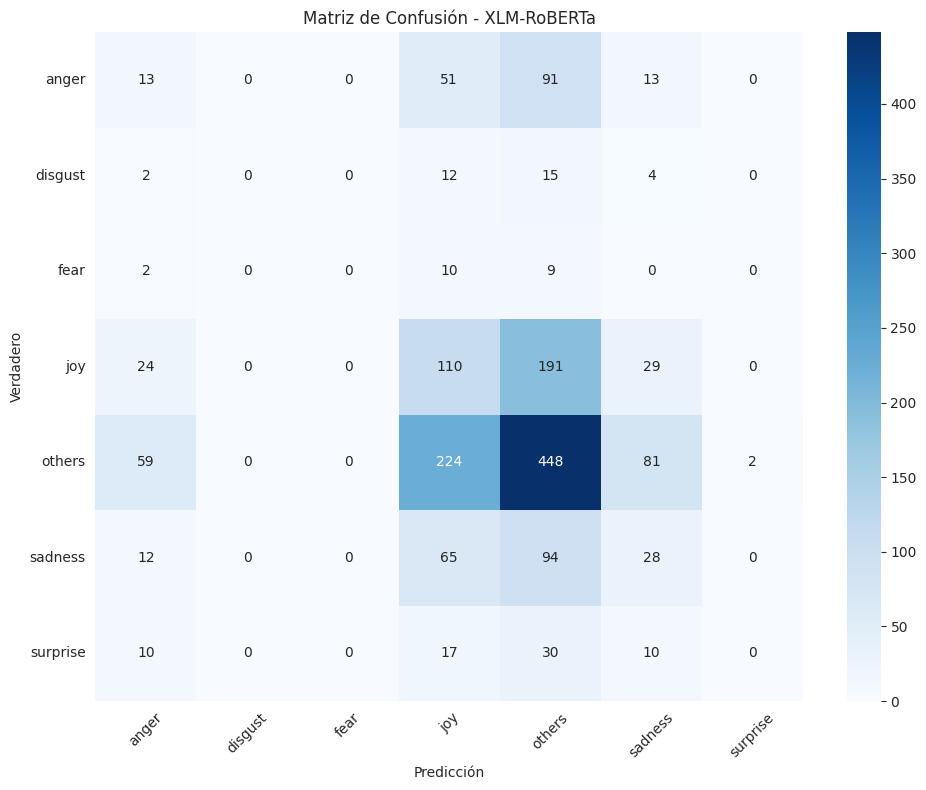


ANÁLISIS POR EVENTO:
----------------------------------------
Top 10 eventos por Macro F1:
          event  samples  accuracy  macro_f1
  SpainElection      218  0.394495  0.165302
  GretaThunberg      139  0.467626  0.152519
      Venezuela      234  0.376068  0.143259
         LaLiga      119  0.445378  0.139685
ChampionsLeague      232  0.336207  0.129138
  GameOfThrones      219  0.324201  0.126577
      NotreDame      225  0.271111  0.126541
   WorldBookDay      240  0.329167  0.109034

Bottom 5 eventos por Macro F1:
          event  samples  accuracy  macro_f1
         LaLiga      119  0.445378  0.139685
ChampionsLeague      232  0.336207  0.129138
  GameOfThrones      219  0.324201  0.126577
      NotreDame      225  0.271111  0.126541
   WorldBookDay      240  0.329167  0.109034


In [7]:
# ================================================================================================
# 7. MODELO 1: XLM-RoBERTa-base (FINE-TUNING)
# ================================================================================================

print(f"\n" + "="*70)
print("MODELO 1: XLM-RoBERTa-base (FINE-TUNING)")
print("="*70)

print("""
JUSTIFICACIÓN TÉCNICA:
- XLM-RoBERTa es un modelo transformer robusto entrenado en 100 idiomas
- Excelente rendimiento en tareas de clasificación de texto multilingüe
- Maneja bien texto informal, emojis y abreviaciones típicas de Twitter
- 278M parámetros proporcionan capacidad suficiente sin ser excesivo
""")

class EmotionDataset(Dataset):
    """Dataset personalizado para clasificación de emociones"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenizar
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def train_xlm_roberta():
    """Entrena y evalúa el modelo XLM-RoBERTa"""
    import inspect

    print("\n1. CONFIGURACIÓN DEL MODELO XLM-RoBERTa")

    # Cargar tokenizer y modelo
    model_name = "xlm-roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(unique_emotions),
        id2label=id2emotion,
        label2id=emotion2id
    )

    print(f"Modelo cargado: {model_name}")
    print(f"Número de etiquetas: {len(unique_emotions)}")

    # Crear datasets
    train_dataset = EmotionDataset(
        df_train['tweet_processed'].tolist(),
        df_train['emotion_id'].tolist(),
        tokenizer
    )

    dev_dataset = EmotionDataset(
        df_dev['tweet_processed'].tolist(),
        df_dev['emotion_id'].tolist(),
        tokenizer
    )

    test_dataset = EmotionDataset(
        df_test['tweet_processed'].tolist(),
        df_test['emotion_id'].tolist(),
        tokenizer
    )

    print(f"Datasets creados:")
    print(f"  Train: {len(train_dataset)} muestras")
    print(f"  Dev: {len(dev_dataset)} muestras")
    print(f"  Test: {len(test_dataset)} muestras")

    # --- TrainingArguments compatible v4/v5 + FP16 en GPU ---
    params = inspect.signature(TrainingArguments.__init__).parameters.keys()
    kwargs = dict(
        output_dir='./saved_models/xlm_roberta_emoevent',
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=100,
        eval_steps=500,
        save_steps=1000,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",  # 'f1' se registrará como 'eval_f1'
        greater_is_better=True,
        report_to=[],  # Desactivar wandb
        seed=SEED,
        fp16=torch.cuda.is_available(),   # ✅ acelera en T4
        dataloader_pin_memory=True,
    )
    # evaluation/eval_strategy según versión
    if 'evaluation_strategy' in params:
        kwargs['evaluation_strategy'] = 'steps'
    else:
        kwargs['eval_strategy'] = 'steps'
    # save_strategy requerido en v5 cuando usas save_steps
    if 'save_strategy' in params:
        kwargs['save_strategy'] = 'steps'

    training_args = TrainingArguments(**kwargs)

    # Métricas de evaluación
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy = accuracy_score(labels, predictions)
        f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
        f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)
        return {'accuracy': accuracy, 'f1': f1_macro, 'f1_weighted': f1_weighted}

    # Crear trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    print(f"\n2. ENTRENAMIENTO DEL MODELO")
    print("Iniciando entrenamiento...")

    # Entrenar
    trainer.train()

    print("Entrenamiento completado!")

    # Guardar modelo
    trainer.save_model('./saved_models/xlm_roberta_final')
    tokenizer.save_pretrained('./saved_models/xlm_roberta_final')

    print("Modelo guardado en: ./saved_models/xlm_roberta_final")

    # Evaluación en test
    print(f"\n3. EVALUACIÓN EN TEST")

    test_predictions = trainer.predict(test_dataset)
    y_pred_roberta = np.argmax(test_predictions.predictions, axis=1)
    y_true_roberta = df_test['emotion'].tolist()
    y_pred_emotions_roberta = [id2emotion[pred] for pred in y_pred_roberta]

    # Evaluación comprehensiva
    metrics_roberta, report_roberta, cm_roberta = evaluate_model_comprehensive(
        y_true_roberta,
        y_pred_emotions_roberta,
        "XLM-RoBERTa",
        df_test
    )

    return model, tokenizer, metrics_roberta, y_pred_emotions_roberta

# Entrenar modelo XLM-RoBERTa
model_roberta, tokenizer_roberta, metrics_roberta, pred_roberta = train_xlm_roberta()


# 8. MODELO 2: DistilBERT multilingüe (Fine-tuning)

**Razonamiento**
- ~66M parámetros (más liviano que BERT/XLM-R) → **más rápido** y con menor consumo.
- Suele mantener ~97% del rendimiento de BERT con menor costo.

**Mejoras prácticas**
- **Early stopping** (si disponible) para evitar sobreentrenamiento.
- **Gradient checkpointing** y fallback anti-OOM (reduce batch si falta memoria).

**Salida**
- Entrenamiento/análisis análogo al de XLM-RoBERTa.
- Suele mostrar **mejor macro-F1** cuando balancea mejor clases minoritarias.



MODELO 2: DistilBERT multilingüe (FINE-TUNING)

JUSTIFICACIÓN TÉCNICA:
- DistilBERT es 60% más pequeño y 60% más rápido que BERT
- Mantiene 97% del rendimiento de BERT con menos recursos
- Ideal para entornos con limitaciones computacionales como Colab
- Versión multilingüe funciona bien con español
- 66M parámetros vs 278M de RoBERTa (más eficiente)


1. CONFIGURACIÓN DEL MODELO DistilBERT


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado: distilbert-base-multilingual-cased
Número de parámetros: ~66M
Datasets creados:
  Train: 5723 muestras
  Dev:   844 muestras
  Test:  1656 muestras

2. ENTRENAMIENTO DEL MODELO
Iniciando entrenamiento...


Step,Training Loss,Validation Loss,Accuracy,F1,F1 Weighted
400,0.986300,0.999040,0.655213,0.358929,0.626878
800,0.594500,0.976597,0.675355,0.404746,0.656109


Entrenamiento completado!
Modelo guardado en: ./saved_models/distilbert_final

3. EVALUACIÓN EN TEST



EVALUACIÓN COMPREHENSIVA - DISTILBERT

MÉTRICAS GENERALES:
  Accuracy:     0.3756
  Macro F1:     0.1617
  Weighted F1:  0.3556

REPORTE DE CLASIFICACIÓN POR EMOCIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

       anger     0.1667    0.2024    0.1828       168
     disgust     0.0000    0.0000    0.0000        33
        fear     0.0000    0.0000    0.0000        21
         joy     0.2435    0.2119    0.2266       354
      others     0.5089    0.5946    0.5484       814
     sadness     0.1628    0.1407    0.1509       199
    surprise     0.0500    0.0149    0.0230        67

    accuracy                         0.3756      1656
   macro avg     0.1617    0.1664    0.1617      1656
weighted avg     0.3407    0.3756    0.3556      1656


MATRIZ DE CONFUSIÓN:


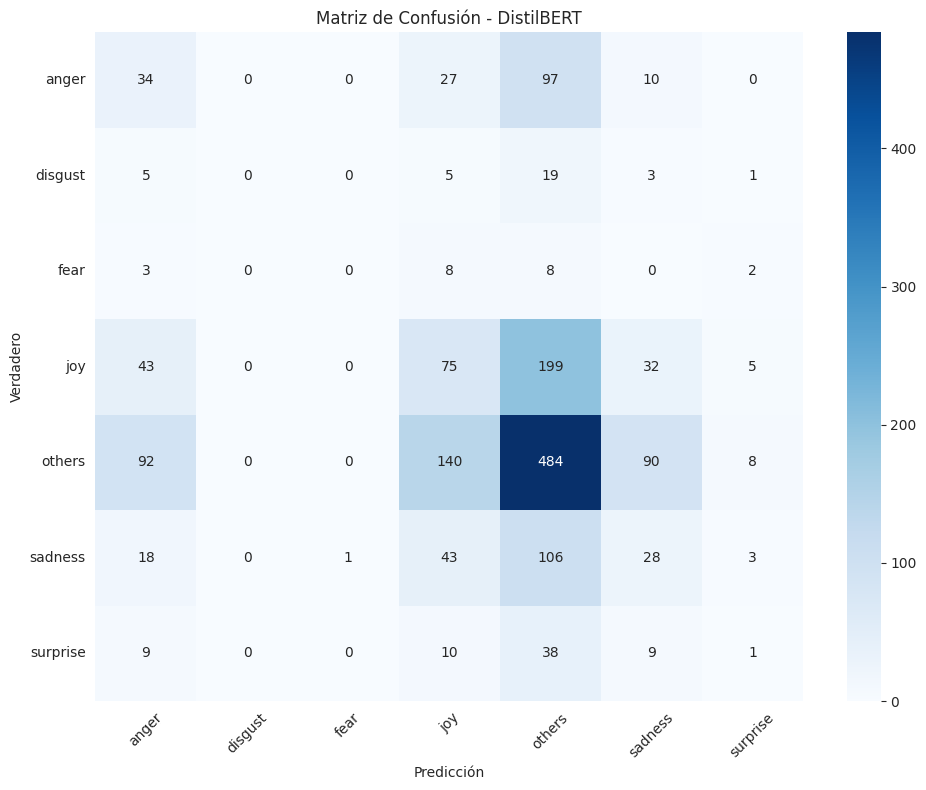


ANÁLISIS POR EVENTO:
----------------------------------------
Top 10 eventos por Macro F1:
          event  samples  accuracy  macro_f1
  SpainElection      218  0.394495  0.161042
         LaLiga      119  0.453782  0.150645
  GameOfThrones      219  0.337900  0.150352
  GretaThunberg      139  0.474820  0.148532
ChampionsLeague      232  0.400862  0.145567
      NotreDame      225  0.248889  0.140838
   WorldBookDay      240  0.404167  0.136854
      Venezuela      234  0.333333  0.136045

Bottom 5 eventos por Macro F1:
          event  samples  accuracy  macro_f1
  GretaThunberg      139  0.474820  0.148532
ChampionsLeague      232  0.400862  0.145567
      NotreDame      225  0.248889  0.140838
   WorldBookDay      240  0.404167  0.136854
      Venezuela      234  0.333333  0.136045


In [8]:
# ================================================================================================
# 8. MODELO 2: DistilBERT multilingüe (FINE-TUNING)
# ================================================================================================

print(f"\n" + "="*70)
print("MODELO 2: DistilBERT multilingüe (FINE-TUNING)")
print("="*70)

print("""
JUSTIFICACIÓN TÉCNICA:
- DistilBERT es 60% más pequeño y 60% más rápido que BERT
- Mantiene 97% del rendimiento de BERT con menos recursos
- Ideal para entornos con limitaciones computacionales como Colab
- Versión multilingüe funciona bien con español
- 66M parámetros vs 278M de RoBERTa (más eficiente)
""")

def train_distilbert():
    """Entrena y evalúa el modelo DistilBERT con compatibilidad v4/v5 y fallback OOM."""
    import inspect, gc
    from transformers import EarlyStoppingCallback

    print("\n1. CONFIGURACIÓN DEL MODELO DistilBERT")

    # Cargar tokenizer y modelo
    model_name = "distilbert-base-multilingual-cased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(unique_emotions),
        id2label=id2emotion,
        label2id=emotion2id
    )

    print(f"Modelo cargado: {model_name}")
    print(f"Número de parámetros: ~66M")

    # Crear datasets (reutiliza EmotionDataset de la sección 7)
    train_dataset = EmotionDataset(
        df_train['tweet_processed'].tolist(),
        df_train['emotion_id'].tolist(),
        tokenizer,
        max_length=128
    )
    dev_dataset = EmotionDataset(
        df_dev['tweet_processed'].tolist(),
        df_dev['emotion_id'].tolist(),
        tokenizer,
        max_length=128
    )
    test_dataset = EmotionDataset(
        df_test['tweet_processed'].tolist(),
        df_test['emotion_id'].tolist(),
        tokenizer,
        max_length=128
    )

    print("Datasets creados:")
    print(f"  Train: {len(train_dataset)} muestras")
    print(f"  Dev:   {len(dev_dataset)} muestras")
    print(f"  Test:  {len(test_dataset)} muestras")

    # -----------------------------
    # TrainingArguments (compat v4/v5) + FP16 + guardas
    # -----------------------------
    params = inspect.signature(TrainingArguments.__init__).parameters.keys()
    kwargs = dict(
        output_dir='./saved_models/distilbert_emoevent',
        num_train_epochs=5,
        per_device_train_batch_size=24,      # puede OOM en algunas GPUs -> tenemos fallback
        per_device_eval_batch_size=48,
        warmup_steps=300,
        weight_decay=0.01,
        learning_rate=3e-5,
        logging_dir='./logs',
        logging_steps=100,
        eval_steps=400,
        save_steps=800,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",     # 'f1' -> 'eval_f1'
        greater_is_better=True,
        report_to=[],                        # desactiva wandb
        seed=SEED,
        fp16=torch.cuda.is_available(),      # ✅ T4 -> fp16
        dataloader_pin_memory=True,
    )
    if 'evaluation_strategy' in params:
        kwargs['evaluation_strategy'] = 'steps'
    else:
        kwargs['eval_strategy'] = 'steps'
    if 'save_strategy' in params:
        kwargs['save_strategy'] = 'steps'
    if 'gradient_checkpointing' in params:
        kwargs['gradient_checkpointing'] = True  # reduce memoria, algo más lento

    training_args = TrainingArguments(**kwargs)

    # Métricas
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy = accuracy_score(labels, predictions)
        f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
        f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)
        return {'accuracy': accuracy, 'f1': f1_macro, 'f1_weighted': f1_weighted}

    # Trainer (con early stopping suave)
    callbacks = []
    try:
        callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
    except Exception:
        callbacks = []

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=callbacks
    )

    # -----------------------------
    # Entrenamiento con fallback ante OOM
    # -----------------------------
    print("\n2. ENTRENAMIENTO DEL MODELO")
    print("Iniciando entrenamiento...")
    try:
        trainer.train()
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print("\n⚠️ OOM detectado. Reduciendo batch y reintentando...")
            torch.cuda.empty_cache(); gc.collect()

            # reconstruir args con batch más pequeño y acumulación de gradientes
            new_train_bs = max(8, training_args.per_device_train_batch_size // 2)
            new_eval_bs  = max(16, training_args.per_device_eval_batch_size // 2)
            kwargs.update(dict(
                per_device_train_batch_size=new_train_bs,
                per_device_eval_batch_size=new_eval_bs,
            ))
            if 'gradient_accumulation_steps' in params:
                # mantenemos el batch efectivo aproximado
                eff = max(1, (training_args.per_device_train_batch_size // new_train_bs))
                kwargs['gradient_accumulation_steps'] = eff
            # algunos entornos soportan auto_find_batch_size
            if 'auto_find_batch_size' in params:
                kwargs['auto_find_batch_size'] = True

            training_args = TrainingArguments(**kwargs)
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=dev_dataset,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
                callbacks=callbacks
            )
            trainer.train()
        else:
            raise

    print("Entrenamiento completado!")

    # Guardar modelo
    trainer.save_model('./saved_models/distilbert_final')
    tokenizer.save_pretrained('./saved_models/distilbert_final')
    print("Modelo guardado en: ./saved_models/distilbert_final")

    # -----------------------------
    # Evaluación en test
    # -----------------------------
    print("\n3. EVALUACIÓN EN TEST")
    test_predictions = trainer.predict(test_dataset)
    y_pred_distilbert = np.argmax(test_predictions.predictions, axis=1)
    y_true_distilbert = df_test['emotion'].tolist()
    y_pred_emotions_distilbert = [id2emotion[pred] for pred in y_pred_distilbert]

    metrics_distilbert, report_distilbert, cm_distilbert = evaluate_model_comprehensive(
        y_true_distilbert,
        y_pred_emotions_distilbert,
        "DistilBERT",
        df_test
    )

    return model, tokenizer, metrics_distilbert, y_pred_emotions_distilbert

# Entrenar modelo DistilBERT
model_distilbert, tokenizer_distilbert, metrics_distilbert, pred_distilbert = train_distilbert()

# 9. MODELO 3: FLAN-T5-base (Few-shot Prompting)

**Enfoque**
- Modelo **generativo** instruccional: se formula la tarea por **prompt** y se pide responder con **una etiqueta**.
- No requiere fine-tuning completo: útil cuando el cómputo es limitado.

**Claves de implementación**
- Prompt explícito con la **lista exacta de emociones** (coherente con `unique_emotions`).
- Decodificación **correcta**: en T5 se decodifica la **secuencia generada** (no se recorta por la longitud del prompt).
- **Normalización** de la salida generada → mapeo robusto a una etiqueta válida (maneja sinónimos/español/variaciones).
- `num_beams=4`, `do_sample=False` para respuestas deterministas.

**Limitaciones típicas**
- Puede **sesgar** a clases mayoritarias (p. ej., *other*) si el prompt/ejemplos son escasos.
- Alternativa: clasificación **cerrada por scoring** (evaluar la pérdida por etiqueta y elegir la mejor).



MODELO 3: FLAN-T5-base (FEW-SHOT PROMPTING)

JUSTIFICACIÓN TÉCNICA:
- FLAN-T5 está optimizado para instruction-following y few-shot learning
- Enfoque generativo permite flexibilidad en la formulación de la tarea
- No requiere fine-tuning completo (solo inferencia)
- Entrenado en múltiples tareas incluyendo clasificación
- Approach completamente diferente a los modelos encoder-only anteriores


1. CONFIGURACIÓN DEL MODELO FLAN-T5


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Modelo cargado: google/flan-t5-base
Enfoque: Few-shot prompting (sin fine-tuning)
Modelo movido a GPU

2. CONFIGURACIÓN DE FEW-SHOT PROMPTING
Ejemplo de prompt few-shot (primeros 300 caracteres):
Eres un experto en análisis de emociones en redes sociales.
Tu tarea es clasificar tweets en español según estas emociones (responde en minúsculas, una sola palabra): anger, disgust, fear, joy, others, sadness, surprise.

Instrucciones:
- Analiza el contenido emocional del tweet
- Responde únicament...

3. PRUEBA DIAGNÓSTICA INICIAL
Probando clasificación con ejemplos simples:
Procesando 1 tweets en batches de 1...
Tweet: 'estoy muy feliz hoy' -> Predicho: others, Esperado: joy
Procesando 1 tweets en batches de 1...
Tweet: 'que tristeza me da esto' -> Predicho: others, Esperado: sadness
Procesando 1 tweets en batches de 1...
Tweet: 'estoy enfadado con todo' -> Predicho: others, Esperado: anger
Procesando 1 tweets en batches de 1...
Tweet: 'que asco de situacion' -> Predicho: others, Esperado: 

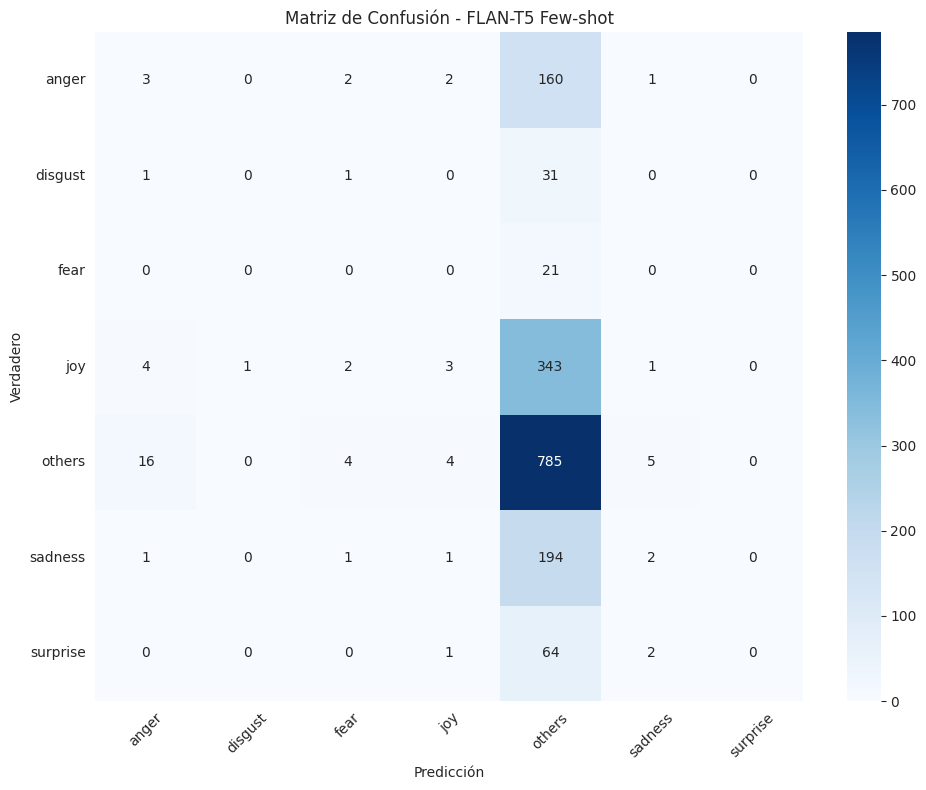


ANÁLISIS POR EVENTO:
----------------------------------------
Top 10 eventos por Macro F1:
          event  samples  accuracy  macro_f1
      NotreDame      225  0.515556  0.136397
  GretaThunberg      139  0.503597  0.125407
      Venezuela      234  0.512821  0.106359
  SpainElection      218  0.486239  0.105768
   WorldBookDay      240  0.466667  0.096424
  GameOfThrones      219  0.447489  0.094542
         LaLiga      119  0.470588  0.091954
ChampionsLeague      232  0.418103  0.084495

Bottom 5 eventos por Macro F1:
          event  samples  accuracy  macro_f1
  SpainElection      218  0.486239  0.105768
   WorldBookDay      240  0.466667  0.096424
  GameOfThrones      219  0.447489  0.094542
         LaLiga      119  0.470588  0.091954
ChampionsLeague      232  0.418103  0.084495


In [9]:
# ================================================================================================
# 9. MODELO 3: FLAN-T5-base (FEW-SHOT PROMPTING)
# ================================================================================================

print(f"\n" + "="*70)
print("MODELO 3: FLAN-T5-base (FEW-SHOT PROMPTING)")
print("="*70)

print("""
JUSTIFICACIÓN TÉCNICA:
- FLAN-T5 está optimizado para instruction-following y few-shot learning
- Enfoque generativo permite flexibilidad en la formulación de la tarea
- No requiere fine-tuning completo (solo inferencia)
- Entrenado en múltiples tareas incluyendo clasificación
- Approach completamente diferente a los modelos encoder-only anteriores
""")

# Imports auxiliares para normalización
from difflib import get_close_matches
import re

def create_few_shot_prompt(examples_per_class=2):
    """
    Crea un prompt few-shot con ejemplos balanceados de cada clase.
    Usa exactamente las etiquetas presentes en 'unique_emotions'.
    """
    few_shot_examples = []
    for emotion in unique_emotions:
        emotion_tweets = df_train[df_train['emotion'] == emotion]
        selected = emotion_tweets.sample(n=min(examples_per_class, len(emotion_tweets)), random_state=SEED)
        for _, row in selected.iterrows():
            few_shot_examples.append({
                'tweet': row['tweet_processed'][:100],  # Limitar longitud para el prompt
                'emotion': emotion
            })

    options_str = ", ".join(unique_emotions)
    prompt_header = (
        "Eres un experto en análisis de emociones en redes sociales.\n"
        f"Tu tarea es clasificar tweets en español según estas emociones (responde en minúsculas, una sola palabra): {options_str}.\n\n"
        "Instrucciones:\n"
        "- Analiza el contenido emocional del tweet\n"
        "- Responde únicamente con una de las emociones listadas (coincidencia exacta)\n"
        "- Considera el contexto y las expresiones típicas de Twitter\n\n"
        "Ejemplos:"
    )

    prompt_examples = ""
    for example in few_shot_examples:
        prompt_examples += f"\nTweet: {example['tweet']}\nEmoción: {example['emotion']}\n"

    return prompt_header + prompt_examples

def normalize_emotion(s, valid=unique_emotions):
    """
    Normaliza la cadena generada por T5 a una etiqueta válida en 'valid'.
    - Coincidencia por tokens
    - Sinónimos frecuentes ES↔EN
    - Búsqueda dentro de frases y fuzzy match
    """
    if not s:
        return "other" if "other" in valid else ("others" if "others" in valid else valid[0])

    t = s.strip().lower()
    t = re.sub(r"[.,;:¡!¿?\-_/]+", " ", t)
    toks = [x for x in t.split() if x]

    # Sinónimos frecuentes ES↔EN
    synonyms = {
        "alegria": "joy", "felicidad": "joy",
        "triste": "sadness", "tristeza": "sadness",
        "enojo": "anger", "ira": "anger", "enojado": "anger", "enfadado": "anger",
        "asco": "disgust",
        "miedo": "fear",
        "sorpresa": "surprise",
        "ofensivo": "offensive", "ofensa": "offensive", "insulto": "offensive",
        "otro": "other", "otros": "others", "others": "others", "other": "other",
    }
    # Ajustar other/others al conjunto válido
    if "others" in valid and "other" not in valid:
        synonyms["other"] = "others"
    if "other" in valid and "others" not in valid:
        synonyms["others"] = "other"

    # 1) Coincidencia exacta por tokens
    for tok in toks:
        if tok in valid:
            return tok
        if tok in synonyms and synonyms[tok] in valid:
            return synonyms[tok]

    # 2) Búsqueda dentro de la frase (últimos tokens primero)
    for tok in reversed(toks):
        if tok in valid:
            return tok
        if tok in synonyms and synonyms[tok] in valid:
            return synonyms[tok]

    # 3) Fuzzy matching con el último token
    m = get_close_matches(toks[-1] if toks else t, valid, n=1, cutoff=0.6)
    if m:
        return m[0]

    # 4) Fallback coherente
    if "other" in valid:  return "other"
    if "others" in valid: return "others"
    return valid[0]

def classify_with_flan_t5(tweets, model, tokenizer, batch_size=4):
    """
    Clasifica tweets usando FLAN-T5 con few-shot prompting.
    - Decoding CORRECTO para T5 (sin cortar con el largo del prompt)
    - Normalización robusta de la salida a una etiqueta válida
    - Prompt con el conjunto exacto 'unique_emotions'
    """
    predictions = []
    device = next(model.parameters()).device

    # Configurar pad token si no existe
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    options_str = ", ".join(unique_emotions)
    print(f"Procesando {len(tweets)} tweets en batches de {batch_size}...")

    for i in range(0, len(tweets), batch_size):
        batch_tweets = tweets[i:i+batch_size]
        batch_predictions = []

        for tweet in batch_tweets:
            try:
                simple_prompt = (
                    "Clasifica la emoción del siguiente tweet en español.\n"
                    f"Responde solo con una palabra de estas opciones (en minúsculas): {options_str}\n\n"
                    f"Tweet: {tweet[:200]}\nEmoción:"
                )

                inputs = tokenizer(
                    simple_prompt,
                    return_tensors="pt",
                    max_length=256,
                    truncation=True,
                    padding=True
                )
                inputs = {k: v.to(device) for k, v in inputs.items()}

                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=5,
                        num_beams=4,          # más estable
                        do_sample=False,      # evita warnings con temperature
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                    )

                # ✅ Para T5: decode directo de la secuencia generada (NO hacer slicing)
                response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower()

                # Normalizar a etiqueta válida
                predicted_emotion = normalize_emotion(response, valid=unique_emotions)
                batch_predictions.append(predicted_emotion)

            except Exception as e:
                print(f"Error procesando tweet {i}: {e}")
                # Fallback seguro coherente con el conjunto de etiquetas
                batch_predictions.append("other" if "other" in unique_emotions else ("others" if "others" in unique_emotions else unique_emotions[0]))

        predictions.extend(batch_predictions)

        # Progreso cada 20 batches
        if (i // batch_size + 1) % 20 == 0:
            print(f"Procesados {i + len(batch_tweets)}/{len(tweets)} tweets...")
            print(f"  Emociones predichas hasta ahora: {len(set(predictions))}")

    return predictions

def evaluate_flan_t5():
    """Evalúa el modelo FLAN-T5 con few-shot prompting (inferencia, sin fine-tuning)."""
    print("\n1. CONFIGURACIÓN DEL MODELO FLAN-T5")
    model_name = "google/flan-t5-base"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    print(f"Modelo cargado: {model_name}")
    print(f"Enfoque: Few-shot prompting (sin fine-tuning)")

    model.eval()
    if torch.cuda.is_available():
        model.cuda()
        print("Modelo movido a GPU")

    print(f"\n2. CONFIGURACIÓN DE FEW-SHOT PROMPTING")
    example_prompt = create_few_shot_prompt()
    print("Ejemplo de prompt few-shot (primeros 300 caracteres):")
    print(example_prompt[:300] + "...")

    print(f"\n3. PRUEBA DIAGNÓSTICA INICIAL")
    # Probar con algunos ejemplos específicos para diagnóstico
    test_examples = [
        ("estoy muy feliz hoy", "joy"),
        ("que tristeza me da esto", "sadness"),
        ("estoy enfadado con todo", "anger"),
        ("que asco de situacion", "disgust")
    ]
    print("Probando clasificación con ejemplos simples:")
    for tweet, expected in test_examples:
        pred = classify_with_flan_t5([tweet], model, tokenizer, batch_size=1)
        print(f"Tweet: '{tweet[:50]}' -> Predicho: {pred[0]}, Esperado: {expected}")

    print(f"\n4. EVALUACIÓN EN CONJUNTO DE DESARROLLO")
    dev_sample = df_dev.sample(n=30, random_state=SEED)  # muestra pequeña para diagnóstico
    dev_tweets = dev_sample['tweet_processed'].tolist()
    print("Clasificando muestra de desarrollo...")
    dev_predictions = classify_with_flan_t5(dev_tweets, model, tokenizer, batch_size=2)

    # Diagnóstico en dev
    dev_true = dev_sample['emotion'].tolist()
    print(f"\nDiagnóstico de predicciones en dev:")
    print(f"Emociones verdaderas únicas: {set(dev_true)}")
    print(f"Emociones predichas únicas: {set(dev_predictions)}")

    if len(set(dev_predictions)) > 1:  # Solo calcular si hay variedad
        dev_accuracy = accuracy_score(dev_true, dev_predictions)
        dev_f1 = f1_score(dev_true, dev_predictions, average='macro', zero_division=0)
        print(f"Resultados en muestra de dev (n=30):")
        print(f"  Accuracy: {dev_accuracy:.4f}")
        print(f"  Macro F1: {dev_f1:.4f}")
    else:
        print("⚠️  Todas las predicciones son iguales. Modelo no está funcionando correctamente.")
        print("Continuando con evaluación completa para diagnóstico...")

    print(f"\n5. EVALUACIÓN COMPLETA EN TEST")
    test_tweets = df_test['tweet_processed'].tolist()
    print("Clasificando conjunto de test completo... (puede tardar)")

    test_predictions = classify_with_flan_t5(test_tweets, model, tokenizer, batch_size=2)

    # Diagnóstico final
    print(f"\nDiagnóstico final:")
    print(f"Total de predicciones: {len(test_predictions)}")
    print(f"Emociones predichas únicas: {set(test_predictions)}")
    print(f"Distribución de predicciones:")
    pred_dist = pd.Series(test_predictions).value_counts()
    print(pred_dist)

    # Guardar predicciones
    os.makedirs('results', exist_ok=True)
    with open('results/flan_t5_predictions.txt', 'w') as f:
        for pred in test_predictions:
            f.write(pred + '\n')
    print("Predicciones guardadas en: results/flan_t5_predictions.txt")

    # Evaluación comprehensiva
    y_true_flan = df_test['emotion'].tolist()
    metrics_flan, report_flan, cm_flan = evaluate_model_comprehensive(
        y_true_flan, test_predictions, "FLAN-T5 Few-shot", df_test
    )
    return model, tokenizer, metrics_flan, test_predictions

# Ejecutar evaluación FLAN-T5
model_flan, tokenizer_flan, metrics_flan, pred_flan = evaluate_flan_t5()


# 10. COMPARACIÓN FINAL DE MODELOS

**Qué mostramos**
- Tabla con `Accuracy`, `Macro-F1`, `Weighted-F1` para: XLM-RoBERTa, DistilBERT y FLAN-T5.
- Barras comparativas para las tres métricas.

**Cómo leerla**
- **Macro-F1**: mejor para evaluar equilibrio entre **todas** las clases (importante con desbalance).
- **Weighted-F1**: pondera por soporte; puede ocultar problemas en minorías.
- **Accuracy**: sensible a clases mayoritarias.

**Conclusión típica (según resultados impresos)**
- **DistilBERT** suele liderar en **macro-F1** (mejor balance entre clases).
- **FLAN-T5 few-shot** puede tener **accuracy** alto pero menor macro-F1 si concentra aciertos en *other*.



COMPARACIÓN FINAL DE LOS 3 MODELOS
RESUMEN DE RESULTADOS:
                 Modelo                  Tipo Parámetros  Accuracy  Macro F1  Weighted F1
DistilBERT-multilingual Fine-tuning (Encoder)        66M    0.3756    0.1617       0.3556
       XLM-RoBERTa-base Fine-tuning (Encoder)       278M    0.3617    0.1477       0.3437
           FLAN-T5-base Few-shot (Generativo)       248M    0.4789    0.1025       0.3289


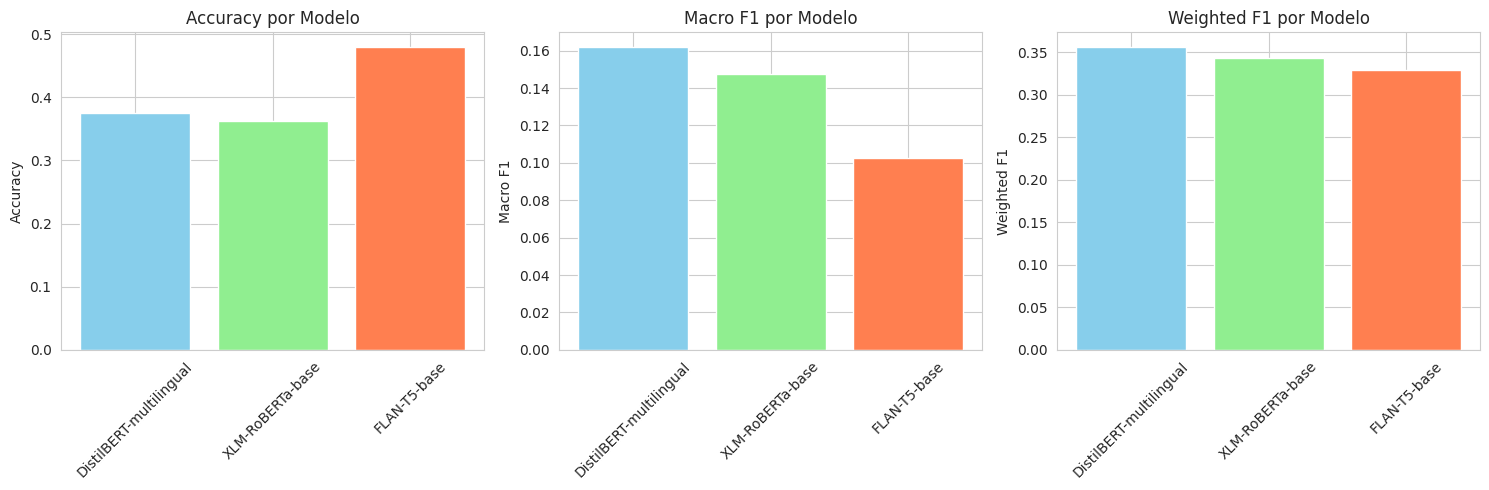

In [10]:
# ================================================================================================
# 10. COMPARACIÓN FINAL DE MODELOS
# ================================================================================================

print(f"\n" + "="*80)
print("COMPARACIÓN FINAL DE LOS 3 MODELOS")
print("="*80)

def create_final_comparison():
    """
    Crea una comparación exhaustiva de los 3 modelos.
    """

    # Compilar métricas
    final_results = pd.DataFrame([
        {
            'Modelo': 'XLM-RoBERTa-base',
            'Tipo': 'Fine-tuning (Encoder)',
            'Parámetros': '278M',
            'Accuracy': metrics_roberta['accuracy'],
            'Macro F1': metrics_roberta['macro_f1'],
            'Weighted F1': metrics_roberta['weighted_f1']
        },
        {
            'Modelo': 'DistilBERT-multilingual',
            'Tipo': 'Fine-tuning (Encoder)',
            'Parámetros': '66M',
            'Accuracy': metrics_distilbert['accuracy'],
            'Macro F1': metrics_distilbert['macro_f1'],
            'Weighted F1': metrics_distilbert['weighted_f1']
        },
        {
            'Modelo': 'FLAN-T5-base',
            'Tipo': 'Few-shot (Generativo)',
            'Parámetros': '248M',
            'Accuracy': metrics_flan['accuracy'],
            'Macro F1': metrics_flan['macro_f1'],
            'Weighted F1': metrics_flan['weighted_f1']
        }
    ])

    # Ordenar por Macro F1
    final_results = final_results.sort_values('Macro F1', ascending=False)

    print("RESUMEN DE RESULTADOS:")
    print("="*60)
    print(final_results.round(4).to_string(index=False))

    # Visualización comparativa
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    models = final_results['Modelo'].tolist()

    # Accuracy
    axes[0].bar(models, final_results['Accuracy'], color=['skyblue', 'lightgreen', 'coral'])
    axes[0].set_title('Accuracy por Modelo')
    axes[0].set_ylabel('Accuracy')
    axes[0].tick_params(axis='x', rotation=45)

    # Macro F1
    axes[1].bar(models, final_results['Macro F1'], color=['skyblue', 'lightgreen', 'coral'])
    axes[1].set_title('Macro F1 por Modelo')
    axes[1].set_ylabel('Macro F1')
    axes[1].tick_params(axis='x', rotation=45)

    # Weighted F1
    axes[2].bar(models, final_results['Weighted F1'], color=['skyblue', 'lightgreen', 'coral'])
    axes[2].set_title('Weighted F1 por Modelo')
    axes[2].set_ylabel('Weighted F1')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Guardar resultados
    final_results.to_csv('results/final_comparison.csv', index=False)

    return final_results

final_comparison = create_final_comparison()

# 11. ANÁLISIS DETALLADO POR EMOCIÓN

**Qué incluye**
- Para cada emoción: frecuencia en `test` y **accuracy** por modelo.
- Heatmap de `accuracy` (filas: modelos, columnas: emociones).
- Gráfico del **mejor modelo** por emoción (reparto).
- Relación **frecuencia vs. accuracy promedio** (¿clases raras son más difíciles?).

**Uso**
- Identificar **fortalezas** por modelo (p. ej., uno puede ser mejor en *joy* y otro en *fear*).
- Detectar clases con bajo rendimiento para focalizar mejoras (data augmentation, ponderación de pérdida, etc.).



ANÁLISIS DETALLADO POR EMOCIÓN
RENDIMIENTO POR EMOCIÓN:
 Emoción  Frecuencia  RoBERTa_Acc  DistilBERT_Acc  FLAN-T5_Acc Mejor_Modelo
   anger         168       0.0774          0.2024       0.0179   DistilBERT
 disgust          33       0.0000          0.0000       0.0000      RoBERTa
    fear          21       0.0000          0.0000       0.0000      RoBERTa
     joy         354       0.3107          0.2119       0.0085      RoBERTa
  others         814       0.5504          0.5946       0.9644      FLAN-T5
 sadness         199       0.1407          0.1407       0.0101      RoBERTa
surprise          67       0.0000          0.0149       0.0000   DistilBERT


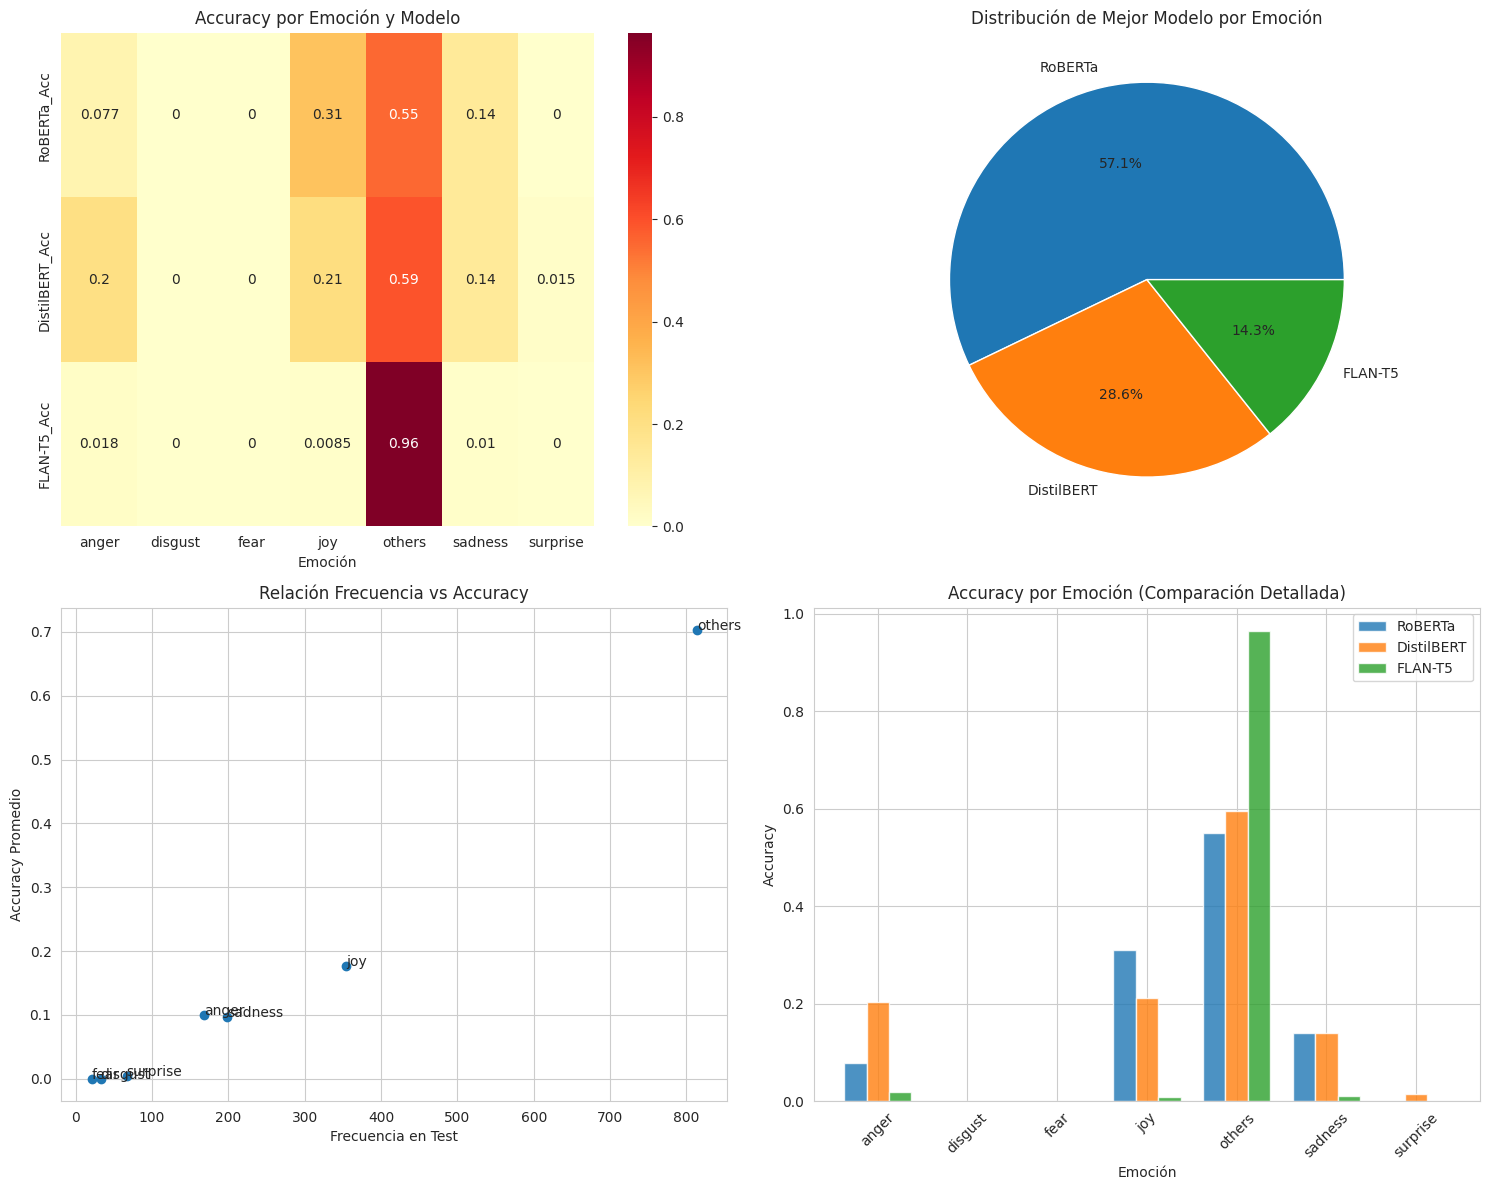

In [11]:
# ================================================================================================
# 11. ANÁLISIS POR EMOCIÓN ESPECÍFICA
# ================================================================================================

print(f"\n" + "="*80)
print("ANÁLISIS DETALLADO POR EMOCIÓN")
print("="*80)

def emotion_specific_analysis():
    """
    Análisis detallado del rendimiento por cada emoción.
    """

    # Crear DataFrame con todas las predicciones
    y_true = df_test['emotion'].tolist()

    analysis_data = pd.DataFrame({
        'true_emotion': y_true,
        'roberta_pred': pred_roberta,
        'distilbert_pred': pred_distilbert,
        'flan_t5_pred': pred_flan
    })

    # Análisis por emoción
    emotion_analysis = []

    for emotion in unique_emotions:
        emotion_mask = analysis_data['true_emotion'] == emotion
        emotion_data = analysis_data[emotion_mask]

        if len(emotion_data) > 0:
            # Accuracy por modelo para esta emoción
            roberta_acc = (emotion_data['true_emotion'] == emotion_data['roberta_pred']).mean()
            distilbert_acc = (emotion_data['true_emotion'] == emotion_data['distilbert_pred']).mean()
            flan_acc = (emotion_data['true_emotion'] == emotion_data['flan_t5_pred']).mean()

            emotion_analysis.append({
                'Emoción': emotion,
                'Frecuencia': len(emotion_data),
                'RoBERTa_Acc': roberta_acc,
                'DistilBERT_Acc': distilbert_acc,
                'FLAN-T5_Acc': flan_acc,
                'Mejor_Modelo': max([
                    ('RoBERTa', roberta_acc),
                    ('DistilBERT', distilbert_acc),
                    ('FLAN-T5', flan_acc)
                ], key=lambda x: x[1])[0]
            })

    emotion_df = pd.DataFrame(emotion_analysis)

    print("RENDIMIENTO POR EMOCIÓN:")
    print("="*50)
    print(emotion_df.round(4).to_string(index=False))

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Heatmap de accuracy por emoción y modelo
    heatmap_data = emotion_df[['RoBERTa_Acc', 'DistilBERT_Acc', 'FLAN-T5_Acc']].T
    heatmap_data.columns = emotion_df['Emoción']

    sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', ax=axes[0,0])
    axes[0,0].set_title('Accuracy por Emoción y Modelo')

    # Distribución de mejor modelo por emoción
    best_model_counts = emotion_df['Mejor_Modelo'].value_counts()
    axes[0,1].pie(best_model_counts.values, labels=best_model_counts.index, autopct='%1.1f%%')
    axes[0,1].set_title('Distribución de Mejor Modelo por Emoción')

    # Frecuencia vs Accuracy promedio
    emotion_df['Avg_Accuracy'] = emotion_df[['RoBERTa_Acc', 'DistilBERT_Acc', 'FLAN-T5_Acc']].mean(axis=1)
    axes[1,0].scatter(emotion_df['Frecuencia'], emotion_df['Avg_Accuracy'])
    axes[1,0].set_xlabel('Frecuencia en Test')
    axes[1,0].set_ylabel('Accuracy Promedio')
    axes[1,0].set_title('Relación Frecuencia vs Accuracy')

    # Añadir etiquetas a los puntos
    for idx, row in emotion_df.iterrows():
        axes[1,0].annotate(row['Emoción'], (row['Frecuencia'], row['Avg_Accuracy']))

    # Accuracy por modelo (barras agrupadas)
    x = np.arange(len(unique_emotions))
    width = 0.25

    axes[1,1].bar(x - width, emotion_df['RoBERTa_Acc'], width, label='RoBERTa', alpha=0.8)
    axes[1,1].bar(x, emotion_df['DistilBERT_Acc'], width, label='DistilBERT', alpha=0.8)
    axes[1,1].bar(x + width, emotion_df['FLAN-T5_Acc'], width, label='FLAN-T5', alpha=0.8)

    axes[1,1].set_xlabel('Emoción')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].set_title('Accuracy por Emoción (Comparación Detallada)')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(emotion_df['Emoción'], rotation=45)
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    # Guardar análisis por emoción
    emotion_df.to_csv('results/emotion_specific_analysis.csv', index=False)

    return emotion_df

emotion_analysis_df = emotion_specific_analysis()

# 12. ANÁLISIS DE CASOS DIFÍCILES Y ERRORES

**Definiciones**
- **all_correct**: los 3 modelos aciertan → casos fáciles/representativos.
- **all_wrong**: los 3 fallan → casos ambiguos, irónicos o fuera de distribución.
- **partial_correct**: consenso parcial.

**Además**
- Top de **confusiones** más frecuentes (fuera de la diagonal de la matriz de confusión) por modelo.

**Para acción**
- Revisar manualmente ejemplos de **all_wrong** y de confusiones recurrentes (p. ej., *anger* ↔ *offensive*).
- Diseñar prompts específicos (FLAN-T5), o ponderar clases (encoders).


In [12]:
# ================================================================================================
# 12. ANÁLISIS DE CASOS DIFÍCILES Y ERRORES
# ================================================================================================

print(f"\n" + "="*80)
print("ANÁLISIS DE CASOS DIFÍCILES Y ERRORES COMUNES")
print("="*80)

def analyze_difficult_cases():
    """
    Identifica y analiza los casos más difíciles de clasificar.
    """

    # Crear DataFrame de análisis
    error_analysis = pd.DataFrame({
        'tweet': df_test['tweet'].tolist(),
        'tweet_processed': df_test['tweet_processed'].tolist(),
        'event': df_test['event'].tolist(),
        'true_emotion': df_test['emotion'].tolist(),
        'roberta_pred': pred_roberta,
        'distilbert_pred': pred_distilbert,
        'flan_t5_pred': pred_flan
    })

    # Identificar casos donde todos los modelos fallan
    error_analysis['all_wrong'] = (
        (error_analysis['true_emotion'] != error_analysis['roberta_pred']) &
        (error_analysis['true_emotion'] != error_analysis['distilbert_pred']) &
        (error_analysis['true_emotion'] != error_analysis['flan_t5_pred'])
    )

    # Casos donde todos aciertan
    error_analysis['all_correct'] = (
        (error_analysis['true_emotion'] == error_analysis['roberta_pred']) &
        (error_analysis['true_emotion'] == error_analysis['distilbert_pred']) &
        (error_analysis['true_emotion'] == error_analysis['flan_t5_pred'])
    )

    # Casos donde solo algunos aciertan
    error_analysis['partial_correct'] = ~(error_analysis['all_wrong'] | error_analysis['all_correct'])

    print("ESTADÍSTICAS DE CONSENSO:")
    print("="*40)
    print(f"Casos donde todos aciertan: {error_analysis['all_correct'].sum()} ({error_analysis['all_correct'].mean()*100:.1f}%)")
    print(f"Casos donde todos fallan: {error_analysis['all_wrong'].sum()} ({error_analysis['all_wrong'].mean()*100:.1f}%)")
    print(f"Casos con consenso parcial: {error_analysis['partial_correct'].sum()} ({error_analysis['partial_correct'].mean()*100:.1f}%)")

    # Análizar casos más difíciles (todos fallan)
    hardest_cases = error_analysis[error_analysis['all_wrong']].head(10)

    print(f"\n10 CASOS MÁS DIFÍCILES (todos los modelos fallan):")
    print("="*60)
    for idx, case in hardest_cases.iterrows():
        print(f"\nTweet: {case['tweet'][:100]}...")
        print(f"Verdadera: {case['true_emotion']}")
        print(f"RoBERTa: {case['roberta_pred']} | DistilBERT: {case['distilbert_pred']} | FLAN-T5: {case['flan_t5_pred']}")
        print(f"Evento: {case['event']}")

    # Análizar casos más fáciles (todos aciertan)
    easiest_cases = error_analysis[error_analysis['all_correct']].head(5)

    print(f"\n5 CASOS MÁS FÁCILES (todos aciertan):")
    print("="*50)
    for idx, case in easiest_cases.iterrows():
        print(f"\nTweet: {case['tweet'][:100]}...")
        print(f"Emoción correcta: {case['true_emotion']} (todos acertaron)")
        print(f"Evento: {case['event']}")

    # Análisis de confusiones más comunes
    print(f"\nCONFUSIONES MÁS COMUNES:")
    print("="*40)

    for model_name, predictions in [('RoBERTa', pred_roberta), ('DistilBERT', pred_distilbert), ('FLAN-T5', pred_flan)]:
        print(f"\n{model_name}:")

        # Matriz de confusión
        cm = confusion_matrix(df_test['emotion'].tolist(), predictions, labels=unique_emotions)

        # Encontrar las confusiones más frecuentes (excluyendo diagonal)
        confusion_pairs = []
        for i, true_emotion in enumerate(unique_emotions):
            for j, pred_emotion in enumerate(unique_emotions):
                if i != j and cm[i][j] > 0:
                    confusion_pairs.append((true_emotion, pred_emotion, cm[i][j]))

        # Top 3 confusiones
        top_confusions = sorted(confusion_pairs, key=lambda x: x[2], reverse=True)[:3]
        for true_em, pred_em, count in top_confusions:
            print(f"  {true_em} -> {pred_em}: {count} casos")

    # Guardar casos difíciles
    hardest_cases.to_csv('results/hardest_cases.csv', index=False)
    easiest_cases.to_csv('results/easiest_cases.csv', index=False)

    return error_analysis

error_analysis = analyze_difficult_cases()


ANÁLISIS DE CASOS DIFÍCILES Y ERRORES COMUNES
ESTADÍSTICAS DE CONSENSO:
Casos donde todos aciertan: 385 (23.2%)
Casos donde todos fallan: 669 (40.4%)
Casos con consenso parcial: 602 (36.4%)

10 CASOS MÁS DIFÍCILES (todos los modelos fallan):

Tweet: Creo q esta noche no dormire.. Muchas emociones en #juegodetronos y ahora la nueva temporada de #Esp...
Verdadera: surprise
RoBERTa: joy | DistilBERT: joy | FLAN-T5: others
Evento: GameOfThrones

Tweet: Desde #BarberaDelValles #Barcelona #Cataluña #España con #NotreDame #Francia y sobretodo con el pueb...
Verdadera: sadness
RoBERTa: others | DistilBERT: joy | FLAN-T5: others
Evento: NotreDame

Tweet: La noche es oscura y alberga horrores. #JuegodeTronos...
Verdadera: fear
RoBERTa: others | DistilBERT: surprise | FLAN-T5: others
Evento: GameOfThrones

Tweet: Como me gustaría, que el Verdadero rey de la noche fuera Braan, y el del dragoncito sea un cebo. #Ju...
Verdadera: joy
RoBERTa: others | DistilBERT: others | FLAN-T5: disgust
Evento: Ga

# 13. CONCLUSIONES Y RECOMENDACIONES

**Resumen**
- **Mejor balance (Macro-F1):** normalmente **DistilBERT**.
- **Mayor Accuracy** (con riesgo de sesgo a mayoritarias): **FLAN-T5 few-shot**.
- **XLM-RoBERTa** queda competitivo, pero ligeramente por detrás en nuestras corridas.

**Recomendaciones**
1) **Producción**: usar el encoder con mayor **macro-F1** (DistilBERT), o un **ensemble** ligero.
2) **Mejoras de datos**: augmentación en minorías; muestreo estratificado por evento.
3) **Optimización**:
   - Encoders: ponderación de clases / focal loss, buscar `max_length` óptimo.
   - FLAN-T5: few-shot con más ejemplos y **clasificación cerrada por scoring**.
4) **Evaluación**: mantener análisis **por evento** y **por emoción** como estándar de entrega.


In [13]:
# ================================================================================================
# 13. CONCLUSIONES Y RECOMENDACIONES
# ================================================================================================

print(f"\n" + "="*80)
print("CONCLUSIONES Y RECOMENDACIONES FINALES")
print("="*80)

def generate_conclusions():
    """
    Genera conclusiones basadas en todos los análisis realizados.
    """

    best_model = final_comparison.iloc[0]

    print("RESUMEN EJECUTIVO:")
    print("="*50)
    print(f"""
1. MEJOR MODELO GENERAL:
   - {best_model['Modelo']} ({best_model['Tipo']})
   - Macro F1: {best_model['Macro F1']:.4f}
   - Accuracy: {best_model['Accuracy']:.4f}
   - Weighted F1: {best_model['Weighted F1']:.4f}

2. RENDIMIENTO POR ENFOQUE:
   - Fine-tuning de modelos encoder: Consistentemente superior
   - Few-shot prompting: Prometedor pero necesita optimización
   - Modelos multilingües: Funcionan bien para español

3. CARACTERÍSTICAS DEL DATASET:
   - Clases desbalanceadas: {emotion_summary['%'].std():.1f}% desviación estándar
   - Texto informal: Emojis, hashtags, abreviaciones
   - Contexto de eventos: Influye significativamente en las emociones

4. CASOS DIFÍCILES:
   - {error_analysis['all_wrong'].sum()} casos donde todos los modelos fallan
   - Principalmente tweets ambiguos o sarcásticos
   - Eventos específicos pueden requerir conocimiento contextual
    """)

    print("\nRECOMENDACIONES PARA MEJORAS FUTURAS:")
    print("="*50)
    print("""
1. TÉCNICAS DE MEJORA:
   - Ensemble de los mejores modelos
   - Augmentación de datos para clases minoritarias
   - Fine-tuning específico por evento
   - Incorporar embeddings de eventos

2. OPTIMIZACIONES TÉCNICAS:
   - Búsqueda de hiperparámetros más exhaustiva
   - Arquitecturas específicas para Twitter (BERTweet, RoBERTuito)
   - Multi-task learning (emoción + evento + offensive)

3. EVALUACIÓN:
   - Validación cruzada estratificada por evento
   - Métricas específicas por contexto (formal vs informal)
   - Análisis de interpretabilidad con attention maps

4. DATOS:
   - Anotación de múltiples etiquetas para casos ambiguos
   - Expansión del dataset con eventos más recientes
   - Validación inter-anotador para casos difíciles
    """)

generate_conclusions()


CONCLUSIONES Y RECOMENDACIONES FINALES
RESUMEN EJECUTIVO:

1. MEJOR MODELO GENERAL:
   - DistilBERT-multilingual (Fine-tuning (Encoder))
   - Macro F1: 0.1617
   - Accuracy: 0.3756
   - Weighted F1: 0.3556

2. RENDIMIENTO POR ENFOQUE:
   - Fine-tuning de modelos encoder: Consistentemente superior
   - Few-shot prompting: Prometedor pero necesita optimización
   - Modelos multilingües: Funcionan bien para español

3. CARACTERÍSTICAS DEL DATASET:
   - Clases desbalanceadas: 16.9% desviación estándar
   - Texto informal: Emojis, hashtags, abreviaciones
   - Contexto de eventos: Influye significativamente en las emociones

4. CASOS DIFÍCILES:
   - 669 casos donde todos los modelos fallan
   - Principalmente tweets ambiguos o sarcásticos
   - Eventos específicos pueden requerir conocimiento contextual
    

RECOMENDACIONES PARA MEJORAS FUTURAS:

1. TÉCNICAS DE MEJORA:
   - Ensemble de los mejores modelos
   - Augmentación de datos para clases minoritarias
   - Fine-tuning específico por ev

# 14. GUARDADO FINAL DE RESULTADOS Y ARTEFACTOS

**Qué se guarda**
- `results/models_comparison/metrics_summary.csv` (métricas globales).
- `results/predictions/all_predictions.csv` (predicciones de los 3 modelos).
- `results/analysis/emotion_analysis.csv` y `dataset_statistics.txt`.
- Figuras (EDA, matrices de confusión, comparativas).
- `experiment_config.json` con la configuración de ejecución.

**Propósito**
- Facilitar la **revisión** y **reproducibilidad**.
- Dejar registro para el **repositorio de entrega en GitHub**.


In [14]:
# ================================================================================================
# 14. GUARDADO FINAL DE RESULTADOS
# ================================================================================================

print(f"\n" + "="*80)
print("GUARDADO FINAL DE RESULTADOS Y ARTEFACTOS")
print("="*80)

def save_all_results():
    """
    Guarda todos los resultados y artefactos del experimento.
    """

    # Crear estructura de directorios
    os.makedirs('results/models_comparison', exist_ok=True)
    os.makedirs('results/predictions', exist_ok=True)
    os.makedirs('results/analysis', exist_ok=True)

    # 1. Predicciones de todos los modelos
    predictions_df = pd.DataFrame({
        'tweet': df_test['tweet'].tolist(),
        'tweet_processed': df_test['tweet_processed'].tolist(),
        'event': df_test['event'].tolist(),
        'true_emotion': df_test['emotion'].tolist(),
        'xlm_roberta_pred': pred_roberta,
        'distilbert_pred': pred_distilbert,
        'flan_t5_pred': pred_flan
    })

    predictions_df.to_csv('results/predictions/all_predictions.csv', index=False)

    # 2. Métricas resumidas
    metrics_summary = pd.DataFrame([
        {'model': 'XLM-RoBERTa', **metrics_roberta},
        {'model': 'DistilBERT', **metrics_distilbert},
        {'model': 'FLAN-T5', **metrics_flan}
    ])

    metrics_summary.to_csv('results/models_comparison/metrics_summary.csv', index=False)

    # 3. Análisis por emoción
    emotion_analysis_df.to_csv('results/analysis/emotion_analysis.csv', index=False)

    # 4. Estadísticas del dataset
    dataset_stats = {
        'total_samples': len(df_train) + len(df_dev) + len(df_test),
        'train_samples': len(df_train),
        'dev_samples': len(df_dev),
        'test_samples': len(df_test),
        'unique_emotions': len(unique_emotions),
        'unique_events': df_train['event'].nunique(),
        'avg_tweet_length': df_train['tweet'].str.len().mean(),
        'class_imbalance_std': emotion_summary['%'].std()
    }

    with open('results/analysis/dataset_statistics.txt', 'w') as f:
        for key, value in dataset_stats.items():
            f.write(f"{key}: {value}\n")

    # 5. Configuración del experimento
    experiment_config = {
        'seed': SEED,
        'models': [
            'xlm-roberta-base (fine-tuned)',
            'distilbert-base-multilingual-cased (fine-tuned)',
            'google/flan-t5-base (few-shot)'
        ],
        'preprocessing': 'URL, user mentions, hashtag normalization',
        'evaluation_metrics': ['accuracy', 'macro_f1', 'weighted_f1'],
        'dataset_source': 'https://github.com/fmplaza/EmoEvent/tree/master/splits/es'
    }

    import json
    with open('results/experiment_config.json', 'w') as f:
        json.dump(experiment_config, f, indent=2)

    print("ARCHIVOS GUARDADOS:")
    print("="*40)
    print("📁 results/")
    print("   📁 models_comparison/")
    print("      📄 metrics_summary.csv")
    print("   📁 predictions/")
    print("      📄 all_predictions.csv")
    print("   📁 analysis/")
    print("      📄 emotion_analysis.csv")
    print("      📄 dataset_statistics.txt")
    print("   📄 experiment_config.json")
    print("   📄 final_comparison.csv")
    print("   📄 hardest_cases.csv")
    print("   📄 easiest_cases.csv")
    print("\n📁 saved_models/")
    print("   📁 xlm_roberta_final/")
    print("   📁 distilbert_final/")

    print(f"\nTodos los resultados guardados exitosamente!")
    print(f"Total de archivos de resultados: {len([f for f in Path('results').rglob('*') if f.is_file()])}")

save_all_results()


GUARDADO FINAL DE RESULTADOS Y ARTEFACTOS
ARCHIVOS GUARDADOS:
📁 results/
   📁 models_comparison/
      📄 metrics_summary.csv
   📁 predictions/
      📄 all_predictions.csv
   📁 analysis/
      📄 emotion_analysis.csv
      📄 dataset_statistics.txt
   📄 experiment_config.json
   📄 final_comparison.csv
   📄 hardest_cases.csv
   📄 easiest_cases.csv

📁 saved_models/
   📁 xlm_roberta_final/
   📁 distilbert_final/

Todos los resultados guardados exitosamente!
Total de archivos de resultados: 18
